# 1. Set up

In [ ]:
from helpers import helpers as h

import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import shap
import matplotlib.pyplot as plt
from joblib import dump

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImPipeline

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold , cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline   
%load_ext blackcellmagic

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("float_format", "{:.2f}".format)

In [4]:
# Data set for predicting stroke, hypertension and avg_glucose_level, with filled NaN values in bmi.
stroke_df = pd.read_csv("stroke_df_nan.csv")

In [5]:
# Data set for predicting bmi, with dropped NaN values in the bmi column.
bmi_df = pd.read_csv("bmi_pred_dataset.csv")
bmi_df.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,heart_hypertenz,log_of_age,age_bins,log_of_avg_glucose_level,glucose_bins,bmi_bins
4901,female,13.00,no,no,no,not_working,rural,103.08,18.60,unknown,no,no,2.56,0-20,4.64,101-150 mg/dl,18-24
4902,female,81.00,no,no,yes,self-employed,urban,125.20,40.00,never smoked,no,no,4.39,81-100,4.83,101-150 mg/dl,35-40
4903,female,35.00,no,no,yes,self-employed,rural,82.99,30.60,never smoked,no,no,3.56,21-40,4.42,51-100 mg/dl,31-35
4904,male,51.00,no,no,yes,private,rural,166.29,25.60,smokes,no,no,3.93,41-60,5.11,151-200 mg/dl,25-30
4905,female,44.00,no,no,yes,govt_job,urban,85.28,26.20,unknown,no,no,3.78,41-60,4.45,51-100 mg/dl,25-30


# 2. Stroke prediction

## 2.1. Feature pre-processing

To select the base line model I decided to use three different sets of features: main (given features), engineered (main plus created by me: bins), logged (age and avg_glucose_level logged to dampen the effect of outlier).

In [6]:
stroke_result = stroke_df.copy()

# Identify and drop our target variable 'stroke' from data frame,

X_main = stroke_result.drop(
    columns=[
        "stroke",
        "heart_hypertenz",
        "log_of_age",
        "age_bins",
        "log_of_avg_glucose_level",
        "glucose_bins",
    ],
    axis=1,
)
X_engineered = stroke_result.drop(
    columns=[
        "stroke",
        "log_of_age",
        "age",
        "log_of_avg_glucose_level",
        "avg_glucose_level",
    ],
    axis=1,
)
X_log = stroke_result.drop(
    columns=[
        "stroke",
        "heart_hypertenz",
        "age",
        "age_bins",
        "avg_glucose_level",
        "glucose_bins",
    ],
    axis=1,
)

# Isolate our dependent variable as a feature
y = stroke_result.stroke

In [7]:
# change y values into 0 and 1, as it was at the beginning:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

* Pre-processor.

In [8]:
# Features in the X_main.

binary_features_main = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "residence_type",
]

one_hot_features_main = ["work_type", "smoking_status"]

numerical_features_main = ["bmi", "age", "avg_glucose_level"]

In [9]:
# Features in the X_engineered.
binary_features_engineered = [
    "gender",
    "hypertension",
    "heart_disease",
    "heart_hypertenz",
    "ever_married",
    "residence_type",
]

one_hot_features_engineered = ["work_type", "smoking_status",  "age_bins", "glucose_bins"]

numerical_features_engineered = ["bmi"]


In [10]:
# Features in the X_log.
binary_features_log = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "residence_type",
]

one_hot_features_log = ["work_type", "smoking_status"]

numerical_features_log = ["bmi", "log_of_age", "log_of_avg_glucose_level"]

In [11]:
binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

one_hot_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_main = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_features_main),
        ("one_hot", one_hot_transformer, one_hot_features_main),
        ("binary", binary_transformer, binary_features_main),
    ]
)

preprocessor_engineered = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_features_engineered),
        ("one_hot", one_hot_transformer, one_hot_features_engineered),
        ("binary", binary_transformer, binary_features_engineered),
    ]
)

preprocessor_log = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_features_log),
        ("one_hot", one_hot_transformer, one_hot_features_log),
        ("binary", binary_transformer, binary_features_log),
    ]
)

resample_1 = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"), random_state=123)
resample_2 = SMOTETomek(random_state=123)
resample_3 = SMOTE(random_state=123)

## 2.2. Cross-validation of baseline models

In this part I will fit all three X_main, X_engineered and X_log and y to the baseline model evaluator, to see what set of features does best and what model performs best. Then I'll pick the models in the best data sets. From the EDA part we saw that there is a huge data imbalance, so I'll try: no resampling and three different resamplers with each data set and show you the best of it. The main metric I use to evaluate model performance is F1 score, as predicting True "1" - that's for stroke cases, is more important than "0". Recall and precision of "1"s is the target values for me, so harmonic mean of them is the best metric for model selection in this phase, the second will be ROC AUC score (False positive vs. True positive rate).

1. X_main data.

In [ ]:
base_data_main = h.base_line(X_main, y, preprocessor_main, resample_2)

In [13]:
# resample_2
base_data_main

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.769304,0.742422,0.769304,0.561304,0.538907,0.837413,0.151384
Decision Tree,0.552664,0.877670,0.552664,0.529539,0.533681,0.552664,0.138733
Random Forest,0.528740,0.919163,0.528740,0.531538,0.529574,0.782181,0.599761
Linear SVC,0.764572,0.733418,0.764572,0.559117,0.532713,0.838746,0.352896
SVC,0.679313,0.803289,0.679313,0.551748,0.549454,0.780892,1.118259
KNN,0.618620,0.829126,0.618620,0.541339,0.542758,0.678098,0.125663
XGB classifier,0.528485,0.925817,0.528485,0.540226,0.532375,0.778643,0.455045
LGBM classifier,0.524575,0.918379,0.524575,0.531806,0.527189,0.777699,0.256756


On the X_main features resample_2 was best and these F1 metrics were highest.

2. X_engineered data.

In [ ]:
base_data_engineered = h.base_line(X_engineered, y, preprocessor_engineered, resample_1)

In [223]:
# resample_1
base_data_engineered

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.748518,0.706408,0.748518,0.553058,0.514501,0.811109,0.183781
Decision Tree,0.522176,0.888629,0.522176,0.514491,0.516052,0.521890,0.164228
Random Forest,0.522209,0.913878,0.522209,0.523326,0.522606,0.738716,0.590007
Linear SVC,0.751336,0.711692,0.751336,0.554096,0.517916,0.813057,0.383267
SVC,0.612382,0.821101,0.612382,0.537427,0.535772,0.732675,1.031087
KNN,0.612241,0.816994,0.612241,0.536743,0.533843,0.683557,0.139253
XGB classifier,0.534214,0.929733,0.534214,0.545376,0.537911,0.739309,0.436885
LGBM classifier,0.532814,0.926994,0.532814,0.541684,0.535385,0.752008,0.271396


Resample_1 looks best on engineered data and here we have XGB and LGBM classifiers are doing best.

3. X_log data.

In [ ]:
base_data_log = h.base_line(X_log, y, preprocessor_log, resample_2)

In [66]:
# resample_2
base_data_log

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.772731,0.719913,0.772731,0.559144,0.526980,0.837106,0.150826
Decision Tree,0.559702,0.873166,0.559702,0.530407,0.534881,0.559702,0.139818
Random Forest,0.534185,0.918772,0.534185,0.535769,0.534674,0.779937,0.636403
Linear SVC,0.771924,0.703863,0.771924,0.557224,0.517880,0.836347,0.335120
SVC,0.670874,0.791156,0.670874,0.547379,0.540078,0.782525,1.150184
KNN,0.580326,0.814641,0.580326,0.526827,0.520243,0.628329,0.131805
XGB classifier,0.532855,0.926991,0.532855,0.548022,0.537665,0.766722,0.449183
LGBM classifier,0.525542,0.920142,0.525542,0.530140,0.527012,0.772500,0.246628


With log transformed numerical data and resample_2 were best results in f1 score.

Conclusion: all three types of data actually showed were similar results, resample_1 and resample_2 actually caused no real difference. No resampling and resample_3 showed worst result in the base line modeling. So for further tuning and modeling I'll stick with the main data set and resample_1, I choose to proceed with Logistic Regression - as I was amazed by it's ROC AUC score, which actually  was highest and I have a thought that there is linear relationship between features. Also I'll continue with SVC (best F1 score) and XGB classifier, also I'll try KNN (quite ok on main data).

* Splitting X_main data set into training, validation and test sets. 

In [14]:
X_train_main, X_rest_main, y_train_main, y_rest_main = train_test_split(
    X_main, y, train_size=0.8, random_state=123
)
X_val_main, X_test_main, y_val_main, y_test_main = train_test_split(
    X_rest_main, y_rest_main, test_size=0.5, random_state=123
)

In [304]:
X_train_main.smoking_status.value_counts()

never smoked    1516
smokes          1344
unknown         1227
Name: smoking_status, dtype: int64

# 2.3. LOGISTIC REGRESSION

## 2.3.1. Logistic regression no hyperparameter tuning

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

lr = LogisticRegression()
pipe_lr = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main),
        ("resample", resample_1),
        ("classifier", lr),
    ]
)
scores = cross_val_score(pipe_lr, X_train_main, y_train_main, cv=cv, scoring="f1_macro")
print(f"Logistic regression F1 score on train data: {scores.mean()}")


Logistic regression F1 score on train data: 0.541342375957518


In [16]:
pipe_lr.fit(X_train_main, y_train_main)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi', 'age',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'residence_type'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('classifier', LogisticRegression())])

In [17]:
y_hat_train_lr = pipe_lr.predict(X_train_main)
y_hat_val_lr = pipe_lr.predict(X_val_main)

In [19]:
labels_stroke = ["no", "yes"]

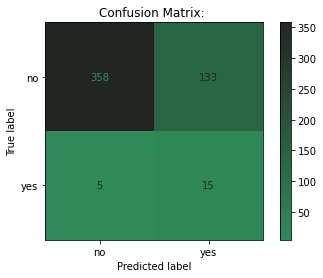

              precision    recall  f1-score   support

          no       0.99      0.73      0.84       491
         yes       0.10      0.75      0.18        20

    accuracy                           0.73       511
   macro avg       0.54      0.74      0.51       511
weighted avg       0.95      0.73      0.81       511




In [21]:
h.plot_classifier_scores(pipe_lr, X_val_main, y_val_main, y_hat_val_lr, labels_stroke)

Not bad in predicting "yes", recall is 0.75 on test data, but precision is only 0.10 (to much False positives). Let's tune the hyperparameters. Total accuracy is not so bad - 0.73.

## 2.3.2. Logistic regression with hyperparameter tuning

In [ ]:
lr_params = h.LR_randomized_search(X_train_main, y_train_main, pipe_lr)

In [23]:
lr_params

{'classifier': LogisticRegression(C=0.750385268090156, class_weight='balanced',
                    solver='newton-cg'),
 'classifier__C': 0.750385268090156,
 'classifier__class_weight': 'balanced',
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

In [24]:
pipe_lr2 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main),
        ("resample", resample_1),
        ("classifier", lr_params["classifier"]),
    ]
)
scores = cross_val_score(pipe_lr2, X_train_main, y_train_main, cv=cv, scoring="f1_macro")
print(f"Logistic regression F1 score on train data: {scores.mean()}")


Logistic regression F1 score on train data: 0.541672849311255


In [25]:
pipe_lr2.fit(X_train_main, y_train_main)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi', 'age',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'residence_type'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('classifier',
                 LogisticRegression(C=0.750385268090156,
                                    class_weight='balanced',
                                    solver='newton-cg'))])

In [26]:
y_hat_train_lr2 = pipe_lr2.predict(X_train_main)
y_hat_val_lr2 = pipe_lr2.predict(X_val_main)

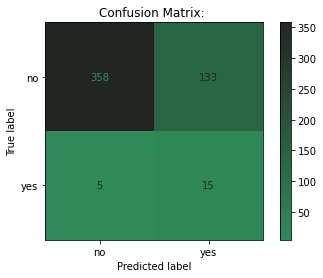

              precision    recall  f1-score   support

          no       0.99      0.73      0.84       491
         yes       0.10      0.75      0.18        20

    accuracy                           0.73       511
   macro avg       0.54      0.74      0.51       511
weighted avg       0.95      0.73      0.81       511




In [28]:
h.plot_classifier_scores(pipe_lr2, X_val_main, y_val_main, y_hat_val_lr2, labels_stroke)

On test data tuned Logistic regression did not improve. The recall of both "no" and "yes" is not so bad actually.
Let's check which features seems most important in the predicting stoke with Logistic regression.

* Coefficients:

In [29]:
features = h.feature_names(pipe_lr2, numerical_features_main, binary_features_main, one_hot_features_main)

In [30]:
coeff = pd.DataFrame(pipe_lr2["classifier"].coef_, columns=features)
coeff_transf = coeff.T
coeff_transf.rename({0:"coefficient"}, axis=1, inplace=True)
coeff_transf

,coefficient
bmi,0.02
age,2.11
avg_glucose_level,0.21
work_type_govt_job,-0.70
work_type_not_working,1.48
work_type_private,0.03
work_type_self-employed,-0.81
smoking_status_never smoked,-0.20
smoking_status_smokes,0.24
smoking_status_unknown,-0.04


In [31]:
important_features = coeff_transf[coeff_transf["coefficient"] >= 0.2]
important_features.index

Index(['age', 'avg_glucose_level', 'work_type_not_working',
       'smoking_status_smokes', 'hypertension'],
      dtype='object')

As in logistic regression I used l2 penalty, there were no features eliminated, so I think features, which got lower coefficients than 0.2, should be dropped and LR tried with less features. 

## 2.3.3. Logistic regression with less features (by coefficients)

In [32]:
X_train_main_less = X_train_main[["age", "avg_glucose_level", "work_type", "smoking_status", "hypertension"]].copy()
X_val_main_less = X_val_main[["age", "avg_glucose_level", "work_type", "smoking_status", "hypertension"]].copy()
X_test_main_less = X_test_main[["age", "avg_glucose_level", "work_type", "smoking_status", "hypertension"]].copy()

In [33]:
one_hot_main_less = ["work_type", "smoking_status"]
binary_main_less = ["hypertension"]
numerical_main_less = ["age", "avg_glucose_level"]

preprocessor_main_less = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_main_less),
        ("one_hot", one_hot_transformer, one_hot_main_less),
        ("binary", binary_transformer, binary_main_less),
    ]
)

Let's check the hyperparameters of Logistic regression for this data only.

In [34]:
pipe_lr3 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main_less),
        ("resample", resample_1),
        ("classifier", LogisticRegression()),
    ]
)
scores = cross_val_score(pipe_lr3, X_train_main_less, y_train_main, cv=cv, scoring="f1_macro")
print(f"Logistic regression F1 score on train data: {scores.mean()}")


Logistic regression F1 score on train data: 0.5333048238459723


F1 score is even lower, lets' try to tune hyperparameters on this data set only.

In [ ]:
lr_params_3 = h.LR_randomized_search(X_train_main_less, y_train_main, pipe_lr3)

In [37]:
pipe_lr4 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main_less),
        ("resample", resample_1),
        ("classifier", LogisticRegression(C=2.6166478337335432e-05, class_weight='balanced',
                   penalty='l2', solver='newton-cg')),
    ]
)
scores = cross_val_score(pipe_lr4, X_train_main_less, y_train_main, cv=cv, scoring="f1_macro")
print(f"Logistic regression F1 score on train data: {scores.mean()}")


Logistic regression F1 score on train data: 0.5337026604899551


In [39]:
pipe_lr4.fit(X_train_main_less, y_train_main)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['hypertension'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('classifier',
                 LogisticRegression(C=2.6166478337335432e-05,
                                    class_weight='balanced',
                                    solver='newton-cg'))])

In [40]:
y_hat_train_lr4 = pipe_lr4.predict(X_train_main_less)
y_hat_val_lr4 = pipe_lr4.predict(X_val_main_less)

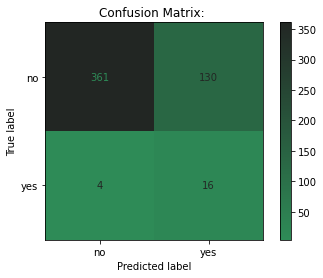

              precision    recall  f1-score   support

          no       0.99      0.74      0.84       491
         yes       0.11      0.80      0.19        20

    accuracy                           0.74       511
   macro avg       0.55      0.77      0.52       511
weighted avg       0.95      0.74      0.82       511




In [42]:
h.plot_classifier_scores(pipe_lr4, X_val_main_less, y_val_main, y_hat_val_lr4, labels_stroke)

The recall of "yes" stroke is actually better - 0.8, but total score of F1 is quite bad. The lower number of features did not help to make the performance better.

* Let's see the ROC AUC and PR AUC.

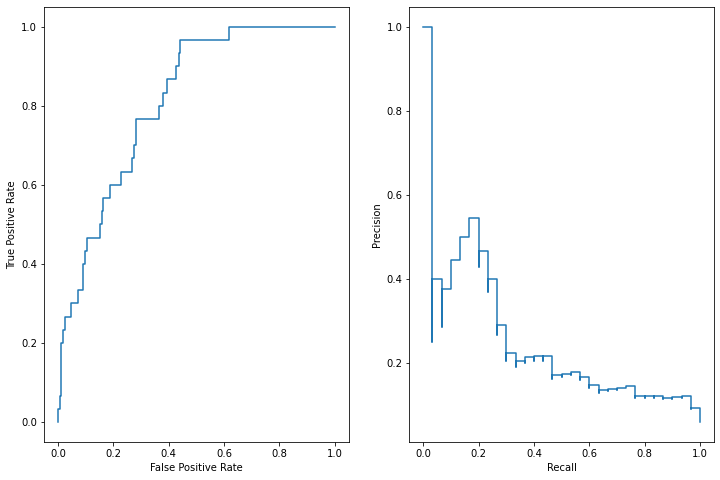

In [250]:
h.plot_roc_auc_pr_auc(pipe_lr4, X_test_main, y_test_main)

# 2.4. Support vector machines classifier

## 2.4.1. SVC no hyperparameter tuning

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

pipe_svc = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main),
        ("resample", resample_1),
        ("classifier", SVC()),
    ]
)
scores = cross_val_score(pipe_svc, X_train_main, y_train_main, cv=cv, scoring="f1_macro")
print(f"Support vector machines classifier F1 score on train data: {scores.mean()}")

Support vector machines classifier F1 score on train data: 0.5419615661123678


In [44]:
pipe_svc.fit(X_train_main, y_train_main)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi', 'age',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'residence_type'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('classifier', SVC())])

In [45]:
y_hat_train_svc = pipe_svc.predict(X_train_main)
y_hat_val_svc = pipe_svc.predict(X_val_main)

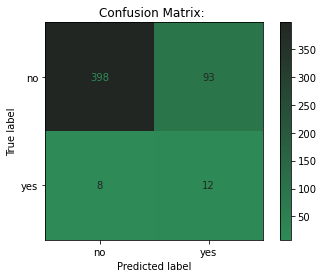

              precision    recall  f1-score   support

          no       0.98      0.81      0.89       491
         yes       0.11      0.60      0.19        20

    accuracy                           0.80       511
   macro avg       0.55      0.71      0.54       511
weighted avg       0.95      0.80      0.86       511




In [47]:
h.plot_classifier_scores(pipe_svc, X_val_main, y_val_main, y_hat_val_svc, labels_stroke)

The recall and f1 score of "yes" stroke is very bad, svc without hyperparameter tuning better predicts "no" than "yes" and that doesn't satisfy me.

## 2.4.2. SVC with tuned hyperparameters

In [263]:
svc_params = h.SVC_randomized_search(X_train_main, y_train_main, pipe_svc)

Best params:
{'classifier': SVC(C=0.750385268090156, class_weight='balanced', gamma=0.1), 'classifier__C': 0.750385268090156, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Best f1 score in randomized search:
0.5449669333962625


In [48]:
pipe_svc2 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main),
        ("resample", resample_1),
        ("classifier", SVC(C=0.750385268090156, class_weight="balanced", gamma=0.1, probability=True)),
    ]
)
scores = cross_val_score(pipe_svc2, X_train_main, y_train_main, cv=cv, scoring="f1_macro")
print(f"Support vector machines tuned F1 score on train data: {scores.mean()}")

Support vector machines tuned F1 score on train data: 0.5425745997755609


In [49]:
pipe_svc2.fit(X_train_main, y_train_main)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi', 'age',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'residence_type'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('classifier',
                 SVC(C=0.750385268090156, class_weight='balanced', gamma=0.1,
                     probability=True))])

In [50]:
y_hat_train_svc2 = pipe_svc2.predict(X_train_main)
y_hat_val_svc2 = pipe_svc2.predict(X_val_main)

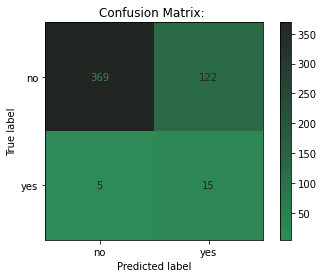

              precision    recall  f1-score   support

          no       0.99      0.75      0.85       491
         yes       0.11      0.75      0.19        20

    accuracy                           0.75       511
   macro avg       0.55      0.75      0.52       511
weighted avg       0.95      0.75      0.83       511




In [52]:
h.plot_classifier_scores(pipe_svc2, X_val_main, y_val_main, y_hat_val_svc2, labels_stroke)

Tuned SVC did better with predicting "yes", the recall and precision of it got higher, but the overall accuracy got lower, as it predicts in total more "yes" and more of them are false. So it's the part of negotiations, what is the price between more patients with False stroke predictions or more False "not stroke" (patients who will not know that they are in danger of stroke).

* Let's see the ROC AUC and precision recall curve plots.

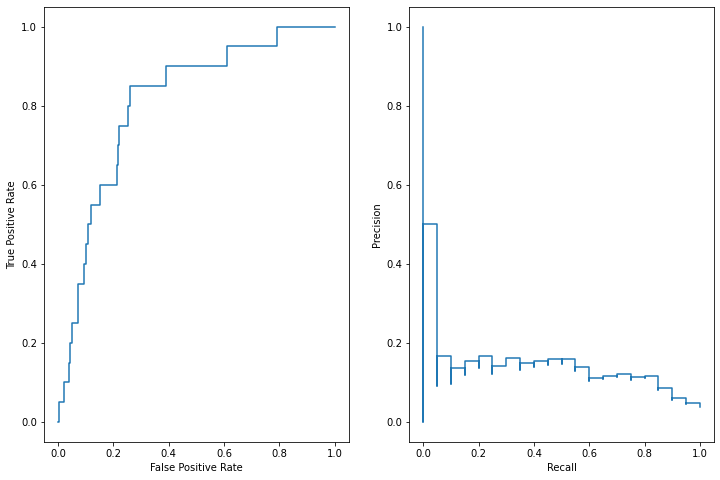

In [269]:
h.plot_roc_auc_pr_auc(pipe_svc2, X_val_main, y_val_main)

* Let's see what features were mostly affecting the prediction by permutation importance and shap values. 

**Permutation importance**

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. How important this feature is for a particular model. If the model is bad by itself, feature importance can be misleading, as in another module the same feature can be very important.

In [ ]:
features_svc = h.feature_names(pipe_svc2, numerical_features_main, binary_features_main, one_hot_features_main)
features_svc

Text(0.5, 0, 'Permutation Importance')

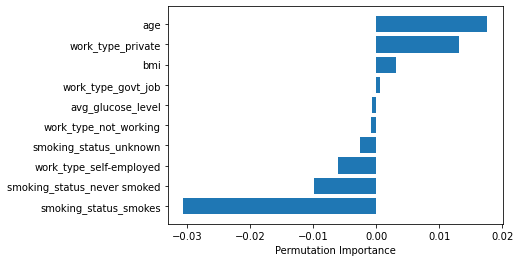

In [74]:
perm_importance = permutation_importance(
    pipe_svc2, X_val_main, y_val_main, n_repeats=30, random_state=123
)

features = np.array(features_svc)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

We have lots of negative values (some work types, smoking status). Negative values for permutation importance indicate that the predictions on the shuffled (or noisy) data are more accurate than the real data. This means that the feature does not contribute much to predictions (importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. So these features do not impact predictions in the right direction. A high value means that the feature is important for the model. In this case, the shuffling of the values brokes the relationship with the target and results in low-quality predictions (high error), [taken from](https://towardsdatascience.com/advanced-permutation-importance-to-explain-predictions-ead7de26eed4). In our case actually all features doesn't seem very promising, highest permutation importance values are only over 0.01 (work_type_private, age), then work_type_govt_job.

**Shapvalues**

In [20]:
# Explain all the predictions in the val set sample, as it took ages for the whole dataset
# use Kernel SHAP to explain test set predictions
# data = shap.sample(preprocessor_main.fit_transform(X_train_main), 100)
# explainer = shap.KernelExplainer(pipe_svc2["classifier"].predict_proba, data, link="logit")
# shap_values = explainer.shap_values(preprocessor_main.transform(X_val_main), nsamples=100)

100%|██████████| 511/511 [14:38:20<00:00, 103.13s/it]      


In [157]:
y_val_main[17]

1

In [50]:
# plot the SHAP values for the stroke "1" output in y_val_main 17 instance
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1][17,:], preprocessor_main.transform(X_val_main)[17,:], link="logit", feature_names=features_svc)

I took the 17'th instance of the y_val_main set, the output was "1" and checked what shows the shap values. It shows that the base value was 0.2774, predict_proba = 0.72 and to this output took avg_glucose_level, age, work_type_private. So these features increased the probability.

In [51]:
# shap.force_plot(explainer.expected_value[1], shap_values[1], preprocessor_main.transform(X_val_main), feature_names=features_svc)

Here we see which features increased the probability of "yes" in the whole validation set. Mostly "age" and "bmi" that pushes up the probability of "yes".

The summary plot shows the same.

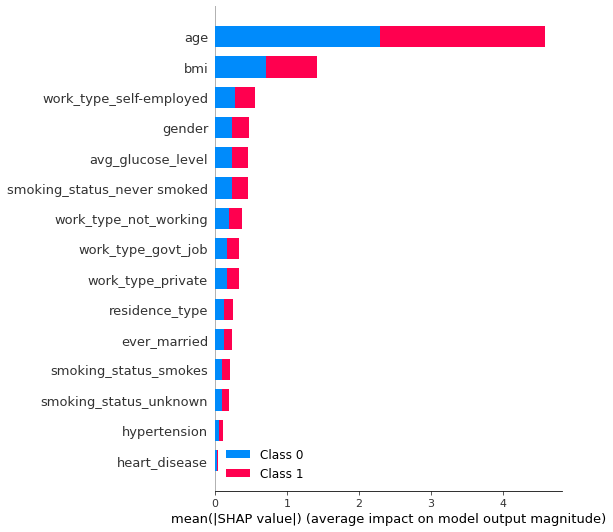

In [35]:
# shap.summary_plot(shap_values, feature_names=features_svc, plot_type="bar")

Most important features in predicting stroke by the shapvalues are: age, bmi, also could be considered work type self employed, gender, average glucose level and never smoked (but they affect the decision in both  ways by the same amount almost, so it depends on certain case, how these other features affect the prediction). 

## 2.4.3. SVC with important features by shapvalues

So depending on shap values and a little on permutation importance, which also showed the importance of age, bmi and some work type, I include these features for further modeling: age, bmi, work type, gender, avg_glucose_level.

In [53]:
X_main_train_svc_less = X_train_main[["age", "bmi", "work_type", "gender", "avg_glucose_level"]].copy()
X_main_test_svc_less = X_test_main[["age", "bmi", "work_type", "gender", "avg_glucose_level"]].copy()


In [54]:
one_hot_svc_less = ["work_type"]
binary_svc_less = ["gender"]
numerical_svc_less = ["age", "bmi", "avg_glucose_level"]

preprocessor_svc_less = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_svc_less),
        ("one_hot", one_hot_transformer, one_hot_svc_less),
        ("binary", binary_transformer, binary_svc_less),
    ]
)

In [55]:
pipe_svc3 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_svc_less),
        ("resample", resample_1),
        ("classifier", SVC()),
    ]
)
scores = cross_val_score(pipe_svc3, X_main_train_svc_less, y_train_main, cv=cv, scoring="f1_macro")
print(f"Support vector machines less features F1 score on train data: {scores.mean()}")

Support vector machines less features F1 score on train data: 0.5174117796714679


In [274]:
svc_params2 = h.SVC_randomized_search(X_main_train_svc_less, y_train_main, pipe_svc3)

Best params:
{'classifier': SVC(C=0.023255373037796706, gamma=10), 'classifier__C': 0.023255373037796706, 'classifier__class_weight': None, 'classifier__gamma': 10, 'classifier__kernel': 'rbf'}
Best f1 score in randomized search:
0.5583897052241049


In [59]:
pipe_svc4 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_svc_less),
        ("resample", resample_1),
        ("classifier", SVC(C=0.023255373037796706, gamma=10, class_weight=None)),
    ]
)
scores = cross_val_score(pipe_svc4, X_main_train_svc_less, y_train_main, cv=cv, scoring="f1_macro")
print(f"Support vector machines less features tuned F1 score on train data: {scores.mean()}")

Support vector machines less features tuned F1 score on train data: 0.5492732875920471


In [60]:
pipe_svc4.fit(X_main_train_svc_less, y_train_main)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('classifier', SVC(C=0.023255373037796706, gamma=10))])

In [61]:
y_hat_train_svc4 = pipe_svc4.predict(X_main_train_svc_less)
y_hat_test_svc4 = pipe_svc4.predict(X_main_test_svc_less)

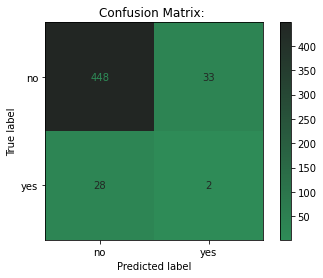

              precision    recall  f1-score   support

          no       0.94      0.93      0.94       481
         yes       0.06      0.07      0.06        30

    accuracy                           0.88       511
   macro avg       0.50      0.50      0.50       511
weighted avg       0.89      0.88      0.88       511




In [63]:
h.plot_classifier_scores(pipe_svc4, X_main_test_svc_less, y_test_main, y_hat_test_svc4, labels_stroke)

Features selection went into the wong way, as the accuracy got better but the price of it: better predictions of "no" and very bad predictions of "yes" - recall only 0.07, f1 score - 0.06. So not in that way.

# 2.5. XGBOOST

## 2.5.1. XGB with hyperparameter tuning

In [ ]:
study = optuna.create_study(direction="minimize", study_name="XGBClassifier")
func = lambda trial: h.xgb_objective(trial, X_train_main, pd.DataFrame(y_train_main), preprocessor_main, resample_1)
study.optimize(func, n_trials=200)

In [66]:
trial = study.best_trial
xgb_params = trial.params

In [67]:
for key, value in xgb_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		n_estimators: 860
		learning_rate: 0.010882507257305767
		num_leaves: 320
		max_depth: 3
		reg_alpha: 0.03902955316732864
		reg_lambda: 78.16298443664692
		gama: 5.412979088641734
		min_child_weight: 8
		scale_pos_weight: 100
	Best value (f1): 0.30532


In [ ]:
pipe_xgb = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main),
        ("resample", resample_1),
        ("classifier", XGBClassifier(**xgb_params)),
    ]
)

scores = cross_val_score(
    pipe_xgb, X_train_main, y_train_main, cv=cv, scoring="f1_macro"
)

In [70]:
print(f"XGBoost classifier F1 score on train data: {scores.mean()}")

XGBoost classifier F1 score on train data: 0.39338472628065907


In [71]:
pipe_xgb.fit(X_train_main, y_train_main)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:12:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "gama", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:12:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi', 'age',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',...
                               learning_rate=0.010882507257305767,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=8, missing=nan,
                               monotone_constraints='()', n_estimators=860,
                               n_jobs=8, num_leaves=320, num_parallel_tree=1,
                               predictor='auto', random_state=0,
                               reg_alpha=0.03902955316732864,
                               reg_lambda=78.16298443664692,
                               scale_pos_weight=100, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [72]:
y_hat_train_xgb = pipe_xgb.predict(X_train_main)
y_hat_val_xgb = pipe_xgb.predict(X_val_main)

Seems obvious overfitting.

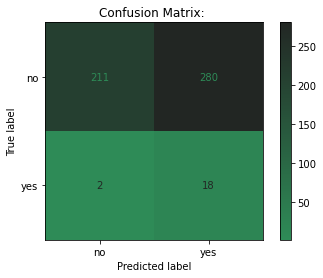

              precision    recall  f1-score   support

          no       0.99      0.43      0.60       491
         yes       0.06      0.90      0.11        20

    accuracy                           0.45       511
   macro avg       0.53      0.66      0.36       511
weighted avg       0.95      0.45      0.58       511




In [74]:
h.plot_classifier_scores(pipe_xgb, X_val_main, y_val_main, y_hat_val_xgb, labels_stroke)

And for sure, in the test set XGB Classifier predicts "yes" with quite good recall - 0.9, but lot's of misclassifications of "no". That's the price of predicting more strokes -> more people to be aware of possible stroke and more job to the doctors.

* Let's see the most important features by the shap values:

In [ ]:
features_xgb = h.feature_names(pipe_xgb, numerical_features_main, binary_features_main, one_hot_features_main)

In [161]:
xgb_explainer = shap.TreeExplainer(pipe_xgb["classifier"])
xgb_shap_values = xgb_explainer(preprocessor_main.transform(X_val_main))

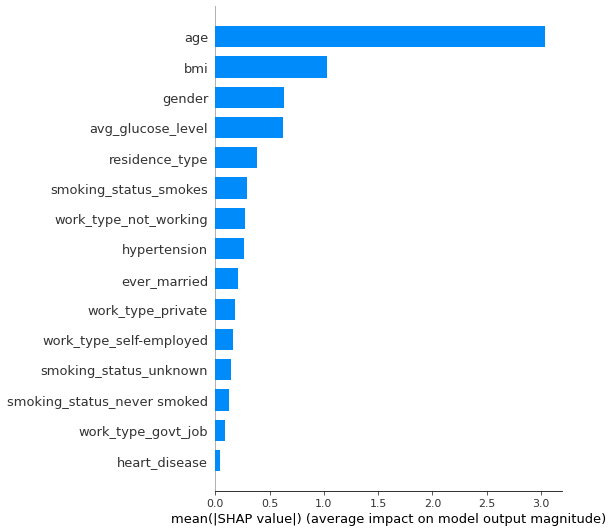

In [162]:
shap.summary_plot(xgb_shap_values, feature_names=features_xgb, plot_type="bar")

## 2.5.2. XGB classifier with less features by shap values

In [163]:
X_train_main_less_xgb = X_train_main[["age", "bmi", "avg_glucose_level", "gender", "residence_type", "smoking_status"]].copy()
X_test_main_less_xgb = X_test_main[["age", "bmi", "avg_glucose_level", "gender", "residence_type", "smoking_status"]].copy()

In [164]:
one_hot_main_less_xgb = ["smoking_status"]
binary_main_less_xgb = ["gender", "residence_type"]
numerical_main_less_xgb = ["age", "bmi", "avg_glucose_level"]

preprocessor_main_less_xgb = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_main_less_xgb),
        ("one_hot", one_hot_transformer, one_hot_main_less_xgb),
        ("binary", binary_transformer, binary_main_less_xgb),
    ]
)

In [ ]:
pipe_xgb2 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_main_less_xgb),
        ("resample", resample_1),
        ("classifier", XGBClassifier(**xgb_params)),
    ]
)

scores = cross_val_score(
    pipe_xgb2, X_train_main_less_xgb, y_train_main, cv=cv, scoring="f1_macro"
)

In [166]:
print(f"XGBoost classifier F1 score on train data: {scores.mean()}")

XGBoost classifier F1 score on train data: 0.44234189363506315


In [167]:
pipe_xgb2.fit(X_train_main_less_xgb, y_train_main)

[23:50:23] WARNING: ..\src\learner.cc:576: 
Parameters: { "gama", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:50:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender',
                                                   'residence_type'])])),
                ('res...
                               learning_rate=0.2660855938548885,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=130,
                               n_jobs=8, num_leaves=1000, num_parallel_tree=1,
                               predictor='auto', random_state=0,
                               reg_alpha=10.23972550337251,
                               reg_lambda=61.80649554925518,
                               scale_pos_weight=100, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [168]:
y_hat_train_xgb2 = pipe_xgb2.predict(X_train_main_less_xgb)
y_hat_test_xgb2 = pipe_xgb2.predict(X_test_main_less_xgb)

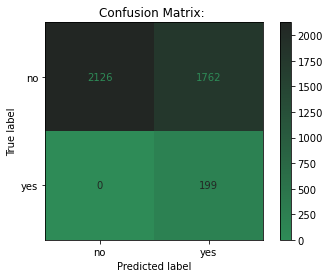

              precision    recall  f1-score   support

          no       1.00      0.55      0.71      3888
         yes       0.10      1.00      0.18       199

    accuracy                           0.57      4087
   macro avg       0.55      0.77      0.45      4087
weighted avg       0.96      0.57      0.68      4087




In [121]:
h.plot_classifier_scores(pipe_xgb2, X_train_main_less_xgb, y_train_main, y_hat_train_xgb2, labels_stroke)


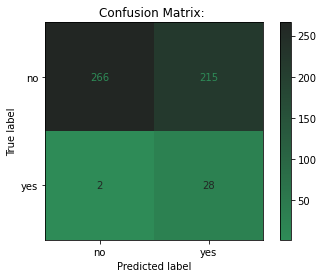

              precision    recall  f1-score   support

          no       0.99      0.55      0.71       481
         yes       0.12      0.93      0.21        30

    accuracy                           0.58       511
   macro avg       0.55      0.74      0.46       511
weighted avg       0.94      0.58      0.68       511




In [169]:
h.plot_classifier_scores(pipe_xgb2, X_test_main_less_xgb, y_test_main, y_hat_test_xgb2, labels_stroke)

It seems that it just guesses "yes" 50 percent of the time, so of course i get good recall of "yes", but the recall of "no" is just 0.55. This model is very imbalanced in predictions.

* SAVING MODEL.

In [87]:
# filename = "stroke_predictor.sav"
# dump(pipe_lr2, filename)

['stroke_predictor.sav']

# 3. Hypertension prediction

## 3.1. Feature pre-processing, base line model

In [88]:
stroke_hypertension = stroke_df.copy()

# Identify and drop our target variable "hypertension" from data frame, 
# I'll try with binned age, glucose data and with continuous.

X_hyp_main = stroke_hypertension.drop(
    columns=[
        "stroke",
        "hypertension",
        "heart_hypertenz",
        "log_of_age",
        "age_bins",
        "log_of_avg_glucose_level",
        "glucose_bins",
    ],
    axis=1,
)
X_hyp_bins = stroke_hypertension.drop(
    columns=[
        "stroke",
        "hypertension",
        "heart_hypertenz",
        "log_of_age",
        "age",
        "log_of_avg_glucose_level",
        "avg_glucose_level",
    ],
    axis=1,
)

# Isolate our dependent variable as a feature
y_hyp = stroke_hypertension.hypertension
y_hyp.replace({"yes":1, "no":0}, inplace=True)

In [89]:
# Types of columns in X_hyp_main
numerical_hyp_main = ["age", "bmi", "avg_glucose_level"]

one_hot_hyp_main = ["work_type", "smoking_status"]

binary_hyp_main = ["gender", "ever_married", "residence_type"]

# Types of columns in X_hyp_bins

numerical_hyp_bins = ["bmi"]

one_hot_hyp_bins = ["work_type", "smoking_status", "age_bins", "glucose_bins"]

binary_hyp_bins = ["gender", "ever_married", "residence_type"]

In [90]:
preprocessor_hyp_main = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_hyp_main),
        ("one_hot", one_hot_transformer, one_hot_hyp_main),
        ("binary", binary_transformer, binary_hyp_main),
    ]
)

preprocessor_hyp_bins = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_hyp_bins),
        ("one_hot", one_hot_transformer, one_hot_hyp_bins),
        ("binary", binary_transformer, binary_hyp_bins),
    ]
)

resample_1 = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"), random_state=123)

**Baseline models**:

* X_hyp_main dataset - with not engineered features.

In [ ]:
base_hyp_main = h.base_line(X_hyp_main, y_hyp, preprocessor_hyp_main, resample_1)

In [308]:
base_hyp_main

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.730147,0.690553,0.730147,0.588678,0.564392,0.801969,0.126108
Decision Tree,0.606405,0.795463,0.606405,0.564074,0.571654,0.606405,0.127445
Random Forest,0.599063,0.835587,0.599063,0.579921,0.586193,0.763253,0.601229
Linear SVC,0.731590,0.685073,0.731590,0.588546,0.561527,0.802136,0.339991
SVC,0.696128,0.692314,0.696128,0.577113,0.555242,0.766018,1.277302
KNN,0.642827,0.741440,0.642827,0.564931,0.561805,0.696047,0.091266
XGB classifier,0.575925,0.858487,0.575925,0.586814,0.579264,0.760147,0.402428
LGBM classifier,0.593665,0.842047,0.593665,0.582485,0.585992,0.762135,0.213258


* X_hyp_bins dataset, with binned "age", "avg_glucose_level":

In [ ]:
base_hyp_bins = h.base_line(X_hyp_bins, y_hyp, preprocessor_hyp_bins, resample_1)

In [310]:
base_hyp_bins

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.726876,0.665302,0.726876,0.584368,0.548682,0.793318,0.182706
Decision Tree,0.584342,0.791350,0.584342,0.551862,0.556943,0.585213,0.156828
Random Forest,0.574159,0.816403,0.574159,0.553997,0.559844,0.730299,0.591496
Linear SVC,0.728085,0.654538,0.728085,0.583869,0.542724,0.792984,0.409271
SVC,0.667222,0.730479,0.667222,0.572120,0.565389,0.741803,1.241419
KNN,0.633113,0.746530,0.633113,0.562081,0.560150,0.684962,0.134508
XGB classifier,0.583345,0.826584,0.583345,0.565627,0.571189,0.739932,0.395682
LGBM classifier,0.589110,0.816015,0.589110,0.564214,0.570812,0.746870,0.244613


According to F1 score, I'll proceed with the X_hyp_main dataset, preprocessor and LGBM classifier, which got the best f1 score - 0.59.

* Splitting data:

In [91]:
X_train_hyp, X_rest_hyp, y_train_hyp, y_rest_hyp = train_test_split(X_hyp_main, y_hyp, train_size=0.8, random_state=123)
X_val_hyp, X_test_hyp, y_val_hyp, y_test_hyp = train_test_split(X_rest_hyp, y_rest_hyp, test_size=0.5, random_state=123)

## 3.2. LGBM Classifier

* Hyperparameter tuning.

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBMClassifier")
func = lambda trial: h.lgbm_objective(trial, X_hyp_main, y_hyp, preprocessor_hyp_main, resample_1)
study.optimize(func, n_trials=20)

In [97]:
trial = study.best_trial
lgbm_params = trial.params

In [98]:
for key, value in lgbm_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		n_estimators: 4
		learning_rate: 0.01706444725848094
		num_leaves: 2960
		max_depth: 7
		min_data_in_leaf: 300
		lambda_l1: 70
		lambda_l2: 15
		min_gain_to_split: 5.892527916229733
	Best value (f1): 0.63169


In [ ]:
pipe_hyp_lgbm = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_hyp_main),
        ("resample", resample_1),
        ("classifier", LGBMClassifier(**lgbm_params)),
    ]
)

scores = cross_val_score(
    pipe_hyp_lgbm, X_train_hyp, y_train_hyp, cv=cv, scoring="f1_macro"
)

In [101]:
print(f"LGBM classifier F1 score on train data: {scores.mean()}")

LGBM classifier F1 score on train data: 0.486911438572635


In [102]:
pipe_hyp_lgbm.fit(X_train_hyp, y_train_hyp)

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=5.892527916229733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.892527916229733
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'ever_married',
                                                   'residence_type'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('classifier',
                 LGBMClassifier(lambda_l1=70, lambda_l2=15,
                                learning_rate=0.01706444725848094, max_depth=7,
                                min_data_in_leaf=300,
                                min_gain_to_split=5.892527916229733,
                                n_estimators=4, num_leaves=2960))])

In [103]:
y_hat_train_lgbm = pipe_hyp_lgbm.predict(X_train_hyp)
y_hat_val_lgbm = pipe_hyp_lgbm.predict(X_val_hyp)

In [104]:
labels_hyp = ["no", "yes"]

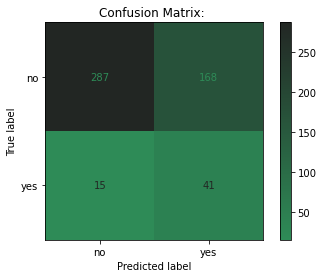

              precision    recall  f1-score   support

          no       0.95      0.63      0.76       455
         yes       0.20      0.73      0.31        56

    accuracy                           0.64       511
   macro avg       0.57      0.68      0.53       511
weighted avg       0.87      0.64      0.71       511




In [106]:
h.plot_classifier_scores(pipe_hyp_lgbm, X_val_hyp, y_val_hyp, y_hat_val_lgbm, labels_hyp)

LGBM predicts "yes" hypertension quite good, the recall is 0.73, precision of "yes" is low - 0.20. Total accuracy 0.7.

* Let's see what features made biggest impact. 

**Shap values**:

In [ ]:
features_hyp = h.feature_names(pipe_hyp_lgbm, numerical_hyp_main, binary_hyp_main, one_hot_hyp_main)
features_hyp

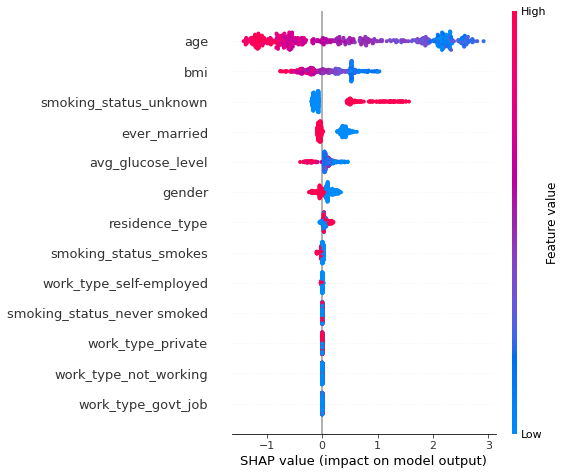

In [198]:
lgbm_explainer = shap.TreeExplainer(pipe_hyp_lgbm["classifier"])
lgbm_shap_values = lgbm_explainer(preprocessor_hyp_main.transform(X_test_hyp))
shap.summary_plot(lgbm_shap_values[:, :, 0], feature_names=features_hyp)

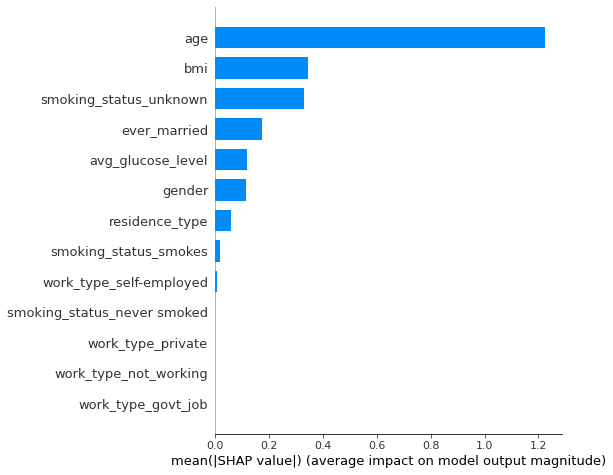

In [199]:
shap.summary_plot(lgbm_shap_values[:, :, 0], feature_names=features_hyp, plot_type="bar")

In [254]:
shap.initjs()
shap.plots.force(lgbm_shap_values[:, :, 0][1], feature_names=features_hyp)

Most impact by "age", "bmi", "ever_married", "gender". Smoking status - unknown actually give sno information,for further improvement, I would fit less features, try to tune more hyperparameters. I'll save this lgbm tuned model.

In [107]:
# filename = "hypertension_predictor.sav"
# dump(pipe_hyp_lgbm, filename)

['hypertension_predictor.sav']

# 4. Average glucose level prediction

## 4.1. Average glucose prediction with regression

### 4.1.1. Feature pre-processing, base - line models

In [108]:
glucose_df = stroke_df.copy()
X_glucose = glucose_df.drop(
    columns=[
        "avg_glucose_level",
        "stroke",
        "log_of_age",
        "age_bins",
        "log_of_avg_glucose_level",
        "glucose_bins",
    ],
    axis=1,
)
y_glucose = glucose_df.avg_glucose_level

In [109]:
numerical_glucose = ["age", "bmi"]

one_hot_glucose = ["work_type", "smoking_status"]

binary_glucose = ["gender", "hypertension", "heart_disease", "ever_married", "residence_type", "heart_hypertenz"]

binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

one_hot_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_glucose = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_glucose),
        ("one_hot", one_hot_transformer, one_hot_glucose),
        ("binary", binary_transformer, binary_glucose),
    ]
)

In [110]:
base_glucose = h.base_line_regression(X_glucose, y_glucose, preprocessor_glucose)

In [332]:
base_glucose

,Mean_absolute_error,Mean_squared_error,Root_mean_squared_error,R2,Fit time
Linear Regression,32.40,1863.77,43.16,0.09,0.02
Elastic Net,32.61,1917.49,43.77,0.06,0.02
Ridge Regression,32.40,1863.65,43.16,0.09,0.01
Lasso regression,32.70,1900.03,43.57,0.07,0.02
Decision Tree Regressor,43.35,3768.40,61.32,-0.84,0.03
Random Forest Regressor,33.67,2017.62,44.89,0.01,0.82
SVR,29.98,2123.59,46.05,-0.04,0.81
KNN Regressor,34.11,2172.25,46.58,-0.06,0.02
XGB Regressor,34.03,2162.53,46.47,-0.06,0.16
LGBM Regressor,32.30,1924.60,43.85,0.06,0.07


So seems all models predicts terribly, so the best is actually Linear and Ridge regression. Lets' try to build Ridge regression. 

* Splitting the data into train, val and test sets. 

In [111]:
X_train_gluc, X_rest_gluc, y_train_gluc, y_rest_gluc = train_test_split(X_glucose, y_glucose, train_size=0.8, random_state=123)
X_val_gluc, X_test_gluc, y_val_gluc, y_test_gluc = train_test_split(X_rest_gluc, y_rest_gluc, test_size=0.5, random_state=123)

### 4.1.2. AVG glucose level Ridge regression

In [ ]:
study = optuna.create_study(direction="maximize", study_name="Ridge")
func = lambda trial: h.ridge_reg_objective(trial, X_glucose, y_glucose, preprocessor_glucose)
study.optimize(func, n_trials=20)

In [113]:
trial = study.best_trial
ridge_params = trial.params

In [114]:
for key, value in ridge_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value: {study.best_value:.5f}')


		alpha: 5.292499686054888
		fit_intercept: False
		tol: 0.009241414372637653
		solver: sparse_cg
	Best value: 43.15468


In [115]:
cv = KFold(n_splits=5, random_state=123, shuffle=True)
pipe_ridge = Pipeline(
    steps=[("preprocessor", preprocessor_glucose), ("regressor", Ridge(**ridge_params))]
)
scores = cross_val_score(
    pipe_ridge,
    X_train_gluc,
    y_train_gluc,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
)

print(
    "Folds: "
    + str(len(scores))
    + ", MSE: "
    + str(np.mean(np.abs(scores)))
    + ", RMSE: "
    + str(np.sqrt(np.mean(np.abs(scores))))
    + ", STD: "
    + str(np.std(scores))
)

Folds: 5, MSE: 1883.2061915536185, RMSE: 43.39592367439157, STD: 118.70052011843373


In [116]:
pipe_ridge.fit(X_train_gluc, y_train_gluc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'residence_type',
                                                   'heart_hypertenz'])])),
                ('regressor',
                 Ridge(alpha=5.292499686054888, fit_intercept=False,
                       solver='sparse_cg', tol=0.009241414372637653))])

In [117]:
# predict future values
y_hat_train_gluc = pipe_ridge.predict(X_train_gluc)
y_hat_val_gluc = pipe_ridge.predict(X_val_gluc)

In [118]:
features_gluc = h.feature_names(pipe_ridge, numerical_glucose, binary_glucose, one_hot_glucose)

In [119]:
# Coefficients.
coeff_parameter = pd.DataFrame(pipe_ridge.named_steps["regressor"].coef_,features_gluc,columns=['Coefficient'])
coeff_parameter

,Coefficient
age,8.35
bmi,6.57
work_type_govt_job,37.01
work_type_not_working,56.85
work_type_private,39.89
work_type_self-employed,38.36
smoking_status_never smoked,58.08
smoking_status_smokes,58.43
smoking_status_unknown,55.59
gender,3.74


Some coefficients of the features are still very high, maybe the coefficient for the penalty (alpha) is too low. Trying to improve this model, I would leave the features with highest coefficients next time.

In [120]:
# Print respective output scores
print(f"r^2: {r2_score(y_train_gluc, y_hat_train_gluc)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_train_gluc, y_hat_train_gluc))}")

r^2: 0.09656142637712573
rmse: 43.21290410795732


In [121]:
# Print respective output scores
print(f"r^2: {r2_score(y_val_gluc, y_hat_val_gluc)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_val_gluc, y_hat_val_gluc))}")

r^2: 0.14430017376296445
rmse: 42.461661247485395


Actually not so bad, 14 percent of variation in the avg_glucose_level in the validation set can be explained by the features in the module and r^2 got higher from the training set, root mean squared error got lower in the validation set.

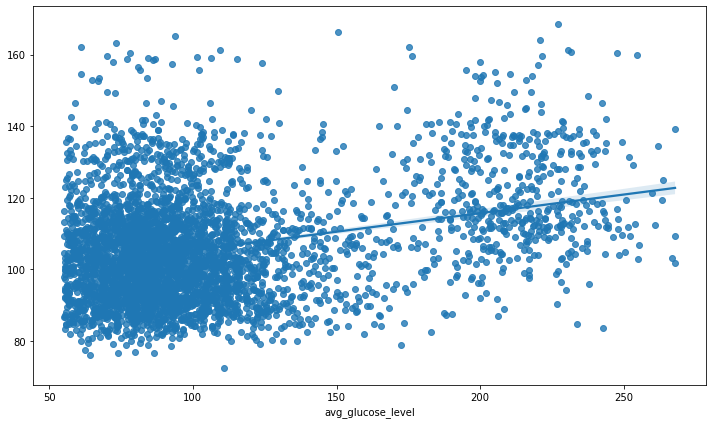

In [344]:
# Real values vs. predicted values in the train set
plt.figure(figsize = (10,6))
sns.regplot(x=y_train_gluc,y=y_hat_train_gluc)

plt.tight_layout();

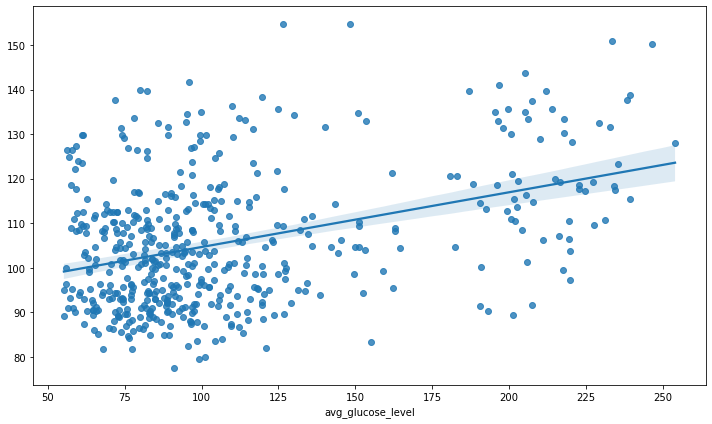

In [345]:
# Real values vs. predicted values in the test set
plt.figure(figsize = (10,6))
sns.regplot(x=y_val_gluc,y=y_hat_val_gluc)

plt.tight_layout();

The variance of residuals. Y values should be the same not depending low or high x values.

In [346]:
residuals = y_hat_train_gluc - y_train_gluc

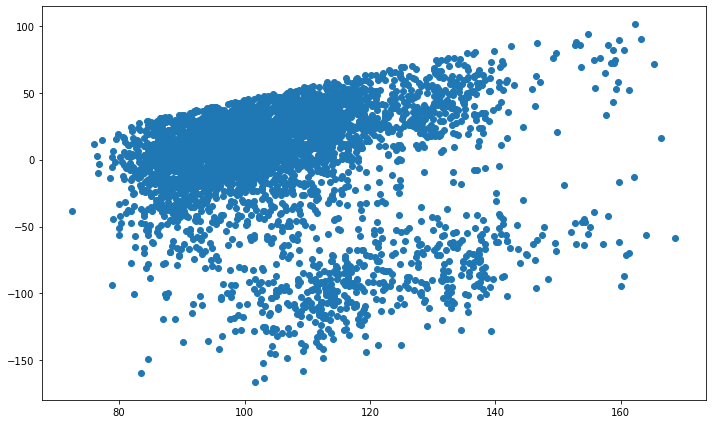

In [347]:
plt.figure(figsize = (10,6))
plt.scatter(y_hat_train_gluc, residuals)
plt.tight_layout()

In [348]:
residuals2 = y_hat_val_gluc - y_val_gluc

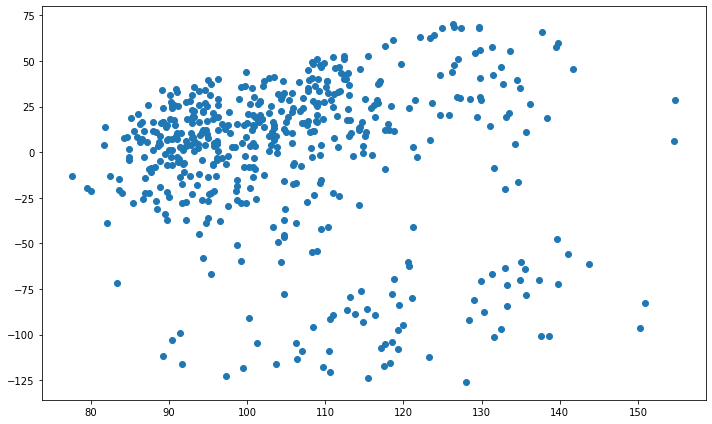

In [349]:
plt.figure(figsize = (10,6))
plt.scatter(y_hat_val_gluc, residuals2)
plt.tight_layout()

From all scatter plots we see like two clusters of y values, from residuals too and the variance of residuals is not constant around zero. What I could do: applying a logistic or square root transformation to the dependent variable, switch to the weighted least squares model [Weighted least squares is a model that can deal with unconstant variances and heteroscedasticity is therefore not a problem](https://towardsdatascience.com/assumptions-of-linear-regression-fdb71ebeaa8b).For the improvement I also would try the features, with the highest coefficients, add polynomial features too.

## 4.2. Average glucose prediction with classification
### 4.2.1. Feature pre-processing, base - line models

In [122]:
y_glucose_class = glucose_df.glucose_bins

In [123]:
y_glucose_class = y_glucose_class.replace(
    {
        "51-100 mg/dl": 0,
        "101-150 mg/dl": 1,
        "151-200 mg/dl": 2,
        "201-250 mg/dl": 3,
        "over 250 mg/dl": 4,
    }
)

We have imbalance in here too, let's try with resampling.

In [124]:
X_train_gluc_class, X_rest_gluc_class, y_train_gluc_class, y_rest_gluc_class = train_test_split(X_glucose, y_glucose_class, train_size=0.8, random_state=123)
X_val_gluc_class, X_test_gluc_class, y_val_gluc_class, y_test_gluc_class = train_test_split(X_rest_gluc_class, y_rest_gluc_class, test_size=0.5, random_state=123)

In [125]:
resample_gluc = SMOTETomek(tomek=TomekLinks(sampling_strategy="not minority"), random_state=123)

In [ ]:
base_line_gluc = h.base_line_multi(X_glucose, y_glucose_class, preprocessor_glucose, resample_gluc)

In [127]:
base_line_gluc

,Balanced accuracy,Accuracy,Recall,Precision,f1,Fit_time
Logistic regression,0.277317,0.356821,0.277317,0.243596,0.221462,0.337716
Decision Tree,0.244371,0.422196,0.244371,0.228344,0.231333,0.183943
Random Forest,0.245830,0.473478,0.245830,0.236134,0.239092,0.939375
Linear SVC,0.218217,0.143668,0.218217,0.228116,0.107627,23.512071
SVC,0.263664,0.389313,0.263664,0.237623,0.231296,2.777577
KNN,0.261951,0.394402,0.261951,0.237315,0.237797,0.156719
XGB classifier,0.237814,0.505187,0.237814,0.231537,0.231094,1.803296
LGBM classifier,0.245296,0.501664,0.245296,0.236853,0.236936,0.593389


Actually all models did quite bad, f1 score is best with LGBM classifier.

### 4.2.2. LBGM classifier with hyperparameter tuning

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBMmulti")
func = lambda trial: h.lgbm_multi_objective(trial, X_glucose, y_glucose_class, preprocessor_glucose, resample_gluc)
study.optimize(func, n_trials=20)

In [129]:
trial = study.best_trial
glucose_lgbm_params = trial.params

In [130]:
for key, value in glucose_lgbm_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value logloss: {study.best_value:.5f}')


		n_estimators: 676
		learning_rate: 0.2826367870420524
		num_leaves: 260
		max_depth: 6
		min_data_in_leaf: 600
		lambda_l1: 0
		lambda_l2: 45
		min_gain_to_split: 14.835916261897502
	Best value logloss: 0.59792


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
pipe_gluc_lgbm = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_glucose),
        ("resample", resample_gluc),
        ("classifier", LGBMClassifier(objective="multiclass", **glucose_lgbm_params)),
    ]
)

scores = cross_val_score(
    pipe_gluc_lgbm, X_train_gluc_class, y_train_gluc_class, cv=cv, scoring="f1_macro"
)

In [132]:
print(f"LGBM classifier F1 score on train data: {scores.mean()}")

LGBM classifier F1 score on train data: 0.23881809442834506


In [133]:
pipe_gluc_lgbm.fit(X_train_gluc_class, y_train_gluc_class)

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=14.835916261897502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.835916261897502
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'eve...,
                                                   'residence_type',
                                                   'heart_hypertenz'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='not '
                                                               'minority'))),
                ('classifier',
                 LGBMClassifier(lambda_l1=0, lambda_l2=45,
                                learning_rate=0.2826367870420524, max_depth=6,
                                min_data_in_leaf=600,
                                min_gain_to_split=14.835916261897502,
                                n_estimators=676, num_leaves=260,
                                objective='multiclass'))])

In [134]:
y_hat_train_gluc_class_lgbm = pipe_gluc_lgbm.predict(X_train_gluc_class)
y_hat_val_gluc_class_lgbm = pipe_gluc_lgbm.predict(X_val_gluc_class)

In [135]:
labels_gluc = ["51-100", "101-150", "151-200", "201-250", "over 250"]

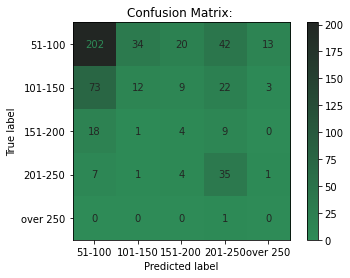

              precision    recall  f1-score   support

      51-100       0.67      0.65      0.66       311
     101-150       0.25      0.10      0.14       119
     151-200       0.11      0.12      0.12        32
     201-250       0.32      0.73      0.45        48
    over 250       0.00      0.00      0.00         1

    accuracy                           0.50       511
   macro avg       0.27      0.32      0.27       511
weighted avg       0.50      0.50      0.49       511




In [137]:
h.plot_classifier_scores(pipe_gluc_lgbm, X_val_gluc_class, y_val_gluc_class, y_hat_val_gluc_class_lgbm, labels_gluc)

From these confusion matrices we see that the performance is not good, total accuracy on the new data only 0.46, recall and some f1 scores in larges classes is a little bit better, but for example class 4 (over 250mg/dl), which had the lowest number of observations  and is the most important - had no correct and almost no guesses at all.

In [138]:
# filename = "glucose_level_predictor.sav"
# dump(pipe_gluc_lgbm, filename)

['glucose_level_predictor.sav']

# 5. Body mass index prediction

## 5.2. Body mass index bins prediction using regression

### 5.1.1. Feature pre-processing, base - line models

I use another data set for bmi prediction, as in the EDA I decided that I must drop NaN values in the BMI column when I will try to predict BMI.

In [142]:
X_bmi = bmi_df.drop(columns= ["stroke", "bmi", "log_of_age", "age_bins", "log_of_avg_glucose_level", "glucose_bins", "bmi_bins"], axis=1)
y_bmi = bmi_df.bmi

In [143]:
numerical_bmi = ["age", "avg_glucose_level"]

one_hot_bmi = ["work_type", "smoking_status"]

binary_bmi = ["gender", "hypertension", "heart_disease", "ever_married", "residence_type", "heart_hypertenz"]

binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

one_hot_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_bmi = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_bmi),
        ("one_hot", one_hot_transformer, one_hot_bmi),
        ("binary", binary_transformer, binary_bmi),
    ]
)

In [37]:
base_bmi = h.base_line_regression(X_bmi, y_bmi, preprocessor_bmi)

In [38]:
base_bmi

,Mean_absolute_error,Mean_squared_error,Root_mean_squared_error,R2,Fit time
Linear Regression,5.08,45.68,6.75,0.24,0.03
Elastic Net,5.53,52.21,7.22,0.13,0.02
Ridge Regression,5.08,45.68,6.75,0.24,0.01
Lasso regression,5.62,53.98,7.34,0.10,0.01
Decision Tree Regressor,7.18,92.22,9.60,-0.55,0.03
Random Forest Regressor,5.24,48.66,6.97,0.19,0.87
SVR,4.82,44.77,6.69,0.25,0.75
KNN Regressor,5.36,51.56,7.18,0.14,0.02
XGB Regressor,5.30,50.11,7.07,0.16,0.20
LGBM Regressor,5.02,45.09,6.71,0.25,0.06


So seems all models predicts terribly, so the best is actually Linear and Ridge regression, also SVR. Lets' try to build Ridge regression. 

* Splitting the data into train, val and test sets. 

In [39]:
X_train_bmi, X_rest_bmi, y_train_bmi, y_rest_bmi = train_test_split(X_bmi, y_bmi, train_size=0.8, random_state=123)
X_val_bmi, X_test_bmi, y_val_bmi, y_test_bmi = train_test_split(X_rest_bmi, y_rest_bmi, test_size=0.5, random_state=123)

### 5.1.2. Ridge regression with hyperparameter tuning

In [ ]:
study = optuna.create_study(direction="maximize", study_name="Ridge")
func = lambda trial: h.ridge_reg_objective(trial, X_bmi, y_bmi, preprocessor_bmi)
study.optimize(func, n_trials=200)

In [41]:
trial = study.best_trial
ridge_bmi_params = trial.params

In [44]:
cv = KFold(n_splits=5, random_state=123, shuffle=True)
regressor = Ridge(**ridge_bmi_params)
pipe_bmi_ridge = Pipeline(
    steps=[("preprocessor", preprocessor_bmi), ("regressor", regressor)]
)
scores = cross_val_score(
    pipe_bmi_ridge,
    X_train_bmi,
    y_train_bmi,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
)

print(
    "Folds: "
    + str(len(scores))
    + ", MSE: "
    + str(np.mean(np.abs(scores)))
    + ", RMSE: "
    + str(np.sqrt(np.mean(np.abs(scores))))
    + ", STD: "
    + str(np.std(scores))
)

Folds: 5, MSE: 46.366818421322876, RMSE: 6.80931849903666, STD: 6.4735100314545715


In [45]:
pipe_bmi_ridge.fit(X_train_bmi, y_train_bmi)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'residence_type',
                                                   'heart_hypertenz'])])),
                ('regressor',
                 Ridge(alpha=9.999932298556795, fit_intercept=False,
                       solver='sparse_cg', tol=0.007611158890176012))])

In [46]:
y_hat_train_bmi = pipe_bmi_ridge.predict(X_train_bmi)
y_hat_val_bmi = pipe_bmi_ridge.predict(X_val_bmi)

In [ ]:
features_bmi = h.feature_names(pipe_bmi_ridge, numerical_bmi, binary_bmi, one_hot_bmi)

In [49]:
# Coefficients.
coeff_parameter_bmi = pd.DataFrame(pipe_bmi_ridge.named_steps["regressor"].coef_,features_bmi,columns=['Coefficient'])
coeff_parameter_bmi

,Coefficient
age,-0.72
avg_glucose_level,0.80
work_type_govt_job,12.65
work_type_not_working,4.92
work_type_private,13.17
work_type_self-employed,12.78
smoking_status_never smoked,14.76
smoking_status_smokes,14.83
smoking_status_unknown,13.92
gender,-0.02


For further improvement, I would select only features with largest coefficient and try to train Ridge with them.

In [50]:
# Print respective output scores
print(f"r^2: {r2_score(y_val_bmi, y_hat_val_bmi)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_val_bmi, y_hat_val_bmi))}")

r^2: 0.2833491094289152
rmse: 6.627317694795501


So almost 30 percent of the variance in the BMI feature can be explained by the features in the dataset, given to the model. The root mean squared error is over 6.6, a lot, as this means that on average each prediction is wrong from the true value in about 6.6.

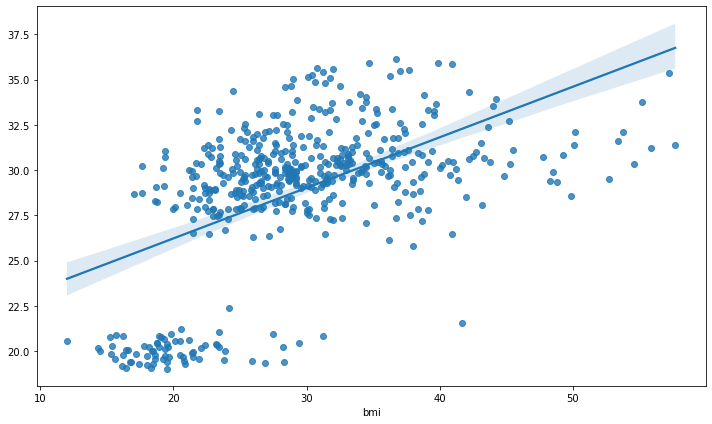

In [51]:
# Real values vs. predicted values in the validation set
plt.figure(figsize = (10,6))
sns.regplot(x=y_val_bmi,y=y_hat_val_bmi)

plt.tight_layout();

We have a clear pattern of  like "outlier" in the bottom of the graph.

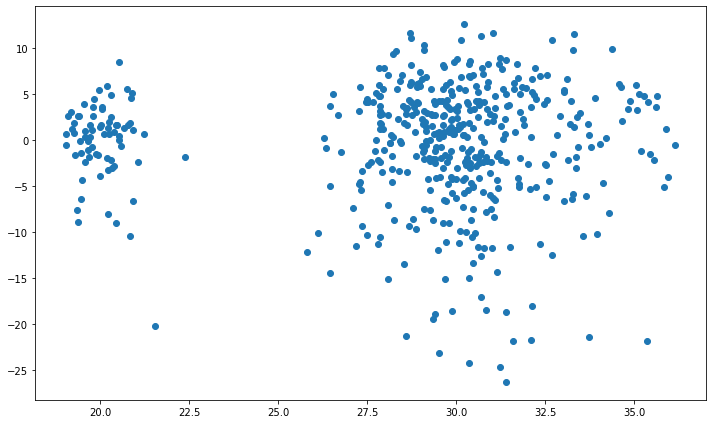

In [52]:
residuals3 = y_hat_val_bmi - y_val_bmi
plt.figure(figsize = (10,6))
plt.scatter(y_hat_val_bmi, residuals3)
plt.tight_layout()

For further improvement, I should check the values that are separate from the main group of values, also there's a gap in the middle of the last scatter plot.

## 5.2. BMI bins prediction using classification

### 5.2.1. Feature pre-processing, base - line models

In [139]:
y_bmi_class = bmi_df.bmi_bins

We have imbalance in here too, let's try with resampling.

In [144]:
y_bmi_class = y_bmi_class.replace({"<=17":0,  "18-24":1,"25-30":2, "31-35":3, "35-40":4, "41<=":5})

In [145]:
X_train_bmi_class, X_test_bmi_class, y_train_bmi_class, y_test_bmi_class = train_test_split(X_bmi, y_bmi_class, train_size=0.8, random_state=123)

In [146]:
resample_bmi = SMOTETomek(tomek=TomekLinks(sampling_strategy="not minority"), random_state=123)

In [ ]:
base_line_bmi = h.base_line_multi(X_bmi, y_bmi_class, preprocessor_bmi, resample_bmi)

In [60]:
base_line_bmi

,Balanced accuracy,Accuracy,Recall,Precision,f1,Fit_time
Logistic regression,0.359123,0.223601,0.359123,0.249981,0.231895,0.238921
Decision Tree,0.279826,0.279862,0.279826,0.251490,0.257372,0.132437
Random Forest,0.283480,0.287812,0.283480,0.255964,0.262883,0.658792
Linear SVC,0.289851,0.154510,0.289851,0.211340,0.148027,8.681259
SVC,0.370325,0.250305,0.370325,0.276634,0.258684,1.041630
KNN,0.312033,0.261724,0.312033,0.252590,0.256429,0.115281
XGB classifier,0.297595,0.301670,0.297595,0.269445,0.276281,1.397748
LGBM classifier,0.308809,0.300856,0.308809,0.271992,0.280864,0.476319


Again, F1 score is best with LGBM classifier. Let's fit.

### 5.2.2. LGBM classifier for BMI bins with hyperparameter tuning

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBMmulti")
func = lambda trial: h.lgbm_multi_objective(trial, X_bmi, y_bmi_class, preprocessor_bmi, resample_bmi)
study.optimize(func, n_trials=200)

In [188]:
trial = study.best_trial
bmi_lgbm_params = trial.params

In [189]:
for key, value in bmi_lgbm_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value logloss: {study.best_value:.5f}')


		n_estimators: 610
		learning_rate: 0.2425845001448105
		num_leaves: 2900
		max_depth: 10
		min_data_in_leaf: 1000
		lambda_l1: 5
		lambda_l2: 15
		min_gain_to_split: 11.354076874997594
	Best value logloss: 0.28922


In [197]:
pipe_bmi_lgbm = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_bmi),
        ("resample", resample_bmi),
        ("classifier", LGBMClassifier(objective="multiclass", **bmi_lgbm_params,)),
    ]
)

scores = cross_val_score(
    pipe_bmi_lgbm, X_train_bmi_class, y_train_bmi_class, cv=cv, scoring="f1_macro"
)

In [198]:
print(f"LGBM classifier F1 score on train data: {scores.mean()}")

LGBM classifier F1 score on train data: 0.2687961900036881


In [199]:
pipe_bmi_lgbm.fit(X_train_bmi_class, y_train_bmi_class)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'residence_type',
                                                   'heart_hypertenz'])])),
                ('resample',
                 SMOTETomek(random_state=123,
                            tomek=TomekLinks(sampling_strategy='not '
                                                               'minority'))),
                ('classifier', LGBMClassifier(objective='multiclass'))])

In [193]:
y_hat_train_bmi_class_lgbm = pipe_bmi_lgbm.predict(X_train_bmi_class)
y_hat_test_bmi_class_lgbm = pipe_bmi_lgbm.predict(X_test_bmi_class)

In [194]:
labels = ["<=17",  "18-24","25-30", "31-35", "35-40", "41<="]

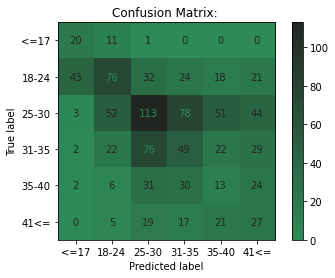

              precision    recall  f1-score   support

        <=17       0.29      0.84      0.43        32
       18-24       0.40      0.21      0.28       214
       25-30       0.00      0.00      0.00       341
       31-35       0.29      0.38      0.33       200
       35-40       0.13      0.26      0.17       106
        41<=       0.14      0.47      0.21        89

    accuracy                           0.22       982
   macro avg       0.21      0.36      0.24       982
weighted avg       0.18      0.22      0.18       982




Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [202]:
h.plot_classifier_scores(pipe_bmi_lgbm, X_test_bmi_class, y_test_bmi_class, y_hat_test_bmi_class_lgbm, labels)

From this confusion matrix we see, that some labels of bmi bins are predicted quite well and others not so good.So the next step would be to decide and select, which bin of BMI is the most important to predict correctly (in my opinion the max overweight as it indicates the worst condition of humans body and health) and try to under sample other bins for better prediction of this one.

In [203]:
filename = "bmi_level_predictor.sav"
dump(pipe_bmi_lgbm, filename)

['bmi_level_predictor.sav']

# 6. Hypertension and average glucose level prediction

I'll try to predict hypertension and average glucose (in bins) level with multioutput model.

In [204]:
hypert_glucose = stroke_df.copy()
hypert_glucose["hypertension"] = hypert_glucose["hypertension"].replace(
    {"yes": 1, "no": 0}
)
hypert_glucose["glucose_bins"] = hypert_glucose["glucose_bins"].replace(
    {
        "51-100 mg/dl": 0,
        "101-150 mg/dl": 1,
        "201-250 mg/dl": 3,
        "151-200 mg/dl": 2,
        "over 250 mg/dl": 4,
    }
)

In [205]:
X_hyp_gluc = hypert_glucose.drop(columns=["hypertension", "avg_glucose_level", "stroke", "heart_hypertenz", "log_of_age", "age_bins", "log_of_avg_glucose_level", "glucose_bins"],axis=1)
y_hyp_gluc = hypert_glucose[["hypertension", "glucose_bins"]]

In [206]:
X_train_hyp_gluc, X_test_hyp_gluc, y_train_hyp_gluc, y_test_hyp_gluc = train_test_split(X_hyp_gluc, y_hyp_gluc, test_size=0.2, random_state=123)

In [207]:
numerical_hyp_gluc = ["age", "bmi"]

one_hot_hyp_gluc = ["work_type", "smoking_status"]

binary_hyp_gluc = ["gender", "heart_disease", "ever_married", "residence_type"]

binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

one_hot_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_hyp_gluc = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_hyp_gluc),
        ("one_hot", one_hot_transformer, one_hot_hyp_gluc),
        ("binary", binary_transformer, binary_hyp_gluc),
    ]
)

* No hyperparameter tuning.

In [208]:
pipe_hyp_gluc_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor_hyp_gluc),
        ("classifier", MultiOutputClassifier(XGBClassifier())),
    ]
)

In [209]:
pipe_hyp_gluc_xgb.fit(X_train_hyp_gluc, y_train_hyp_gluc)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:10:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:10:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'ever_married',
                                                   'res...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method=None,
                                                               validate_parameters=None,
                                                               verbosity=None)))])

Let's check the accuracy score.

In [210]:
print(pipe_hyp_gluc_xgb.score(X_train_hyp_gluc, y_train_hyp_gluc))

0.7866405676535356


In [211]:
y_hat_train_hyp_gluc = pipe_hyp_gluc_xgb.predict(X_train_hyp_gluc)
y_hat_test_hyp_gluc = pipe_hyp_gluc_xgb.predict(X_test_hyp_gluc)

In [212]:
y_train_hyp_gluc_array = y_train_hyp_gluc.values
y_test_hyp_gluc_array = y_test_hyp_gluc.values

* For the hypertension predictions.

In [213]:
labels_gluc = ["51-100", "101-150",  "151-200", "201-250", "over 250"]

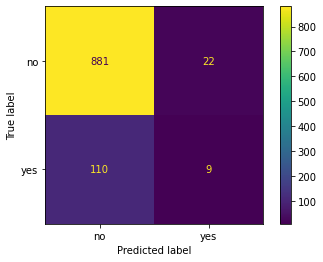

In [214]:
cm = confusion_matrix(y_test_hyp_gluc_array[:,0], y_hat_test_hyp_gluc[:,0], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
disp.plot()

In [215]:
report = classification_report(y_test_hyp_gluc_array[:,0], y_hat_test_hyp_gluc[:,0], target_names=["no", "yes"])
print(report)

              precision    recall  f1-score   support

          no       0.89      0.98      0.93       903
         yes       0.29      0.08      0.12       119

    accuracy                           0.87      1022
   macro avg       0.59      0.53      0.53      1022
weighted avg       0.82      0.87      0.84      1022



Models just do not guess "yes" at all and that's why the accuracy is quite ok, as it keeps guessing "no" most of the time. It's inefficient in predicting hypertension disease.

* For the average glucose level predictions:

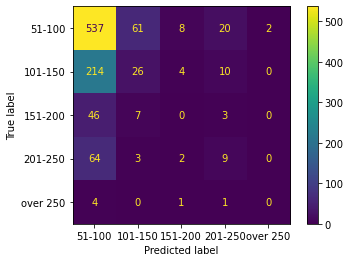

In [216]:
cm_gluc = confusion_matrix(
    y_test_hyp_gluc_array[:, 1], y_hat_test_hyp_gluc[:, 1], labels=[0, 1, 2, 3, 4]
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_gluc,
    display_labels=labels_gluc,
)
disp.plot()

In [217]:
report = classification_report(
    y_test_hyp_gluc_array[:, 1],
    y_hat_test_hyp_gluc[:, 1],
    target_names=labels_gluc,
)
print(report)

              precision    recall  f1-score   support

      51-100       0.62      0.86      0.72       628
     101-150       0.27      0.10      0.15       254
     151-200       0.00      0.00      0.00        56
     201-250       0.21      0.12      0.15        78
    over 250       0.00      0.00      0.00         6

    accuracy                           0.56      1022
   macro avg       0.22      0.21      0.20      1022
weighted avg       0.46      0.56      0.49      1022



Overall the accuracy is not so bad, the recall of lower classes is not pleasant.

* Let's tune the hyperparameters.

In [ ]:
xgb_multi_params = h.xgb_multioutput_randomized_search(pipe_hyp_gluc_xgb, X_train_hyp_gluc, y_train_hyp_gluc)

In [103]:
xgb_multi_params

{'classifier__estimator__colsample_bytree': 0.3,
 'classifier__estimator__gamma': 0.4,
 'classifier__estimator__learning_rate': 0.2,
 'classifier__estimator__max_depth': 8,
 'classifier__estimator__min_child_weight': 5,
 'classifier__estimator__n_estimators': 720,
 'classifier__estimator__num_leaves': 100,
 'classifier__estimator__reg_alpha': 25.994917379678725,
 'classifier__estimator__reg_lambda': 0.0010247695548518448,
 'classifier__estimator__scale_pos_weight': 4}

* Let's tune the model.

In [372]:
pipe_hyp_gluc_xgb2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_hyp_gluc),
        (
            "classifier",
            MultiOutputClassifier(
                XGBClassifier(
                    colsample_bytree=0.3,
                    gamma=0.4,
                    learning_rate=0.2,
                    max_depth=8,
                    min_child_weight=5,
                    n_estimators=720,
                    num_leaves=100,
                    reg_alpha=25.994917379678725,
                    reg_lambda=0.0010247695548518448,
                    scale_pos_weight=4,
                )
            ),
        ),
    ]
)

In [373]:
pipe_hyp_gluc_xgb2.fit(X_train_hyp_gluc, y_train_hyp_gluc)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:34:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:34:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_leaves", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:34

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'ever_married',
                                                   'res...
                                                               learning_rate=0.2,
                                                               max_delta_step=None,
                                                               max_depth=8,
                                                               min_child_weight=5,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=720,
                                                               n_jobs=None,
                                                               num_leaves=100,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=25.994917379678725,
                                                               reg_lambda=0.0010247695548518448,
                                                               scale_pos_weight=4,
                                                               subsample=None,
                                                               tree_method=None,
                                                               validate_parameters=None,
                                                               verbosity=None)))])

Let's check the accuracy score.

In [390]:
print(pipe_hyp_gluc_xgb2.score(X_train_hyp_gluc, y_train_hyp_gluc))

0.5370687545877172


In [108]:
y_hat_train_hyp_gluc2 = pipe_hyp_gluc_xgb2.predict(X_train_hyp_gluc)
y_hat_test_hyp_gluc2 = pipe_hyp_gluc_xgb2.predict(X_test_hyp_gluc)

In [109]:
y_train_hyp_gluc_array2 = y_train_hyp_gluc.values
y_test_hyp_gluc_array2 = y_test_hyp_gluc.values

* For the hypertension predictions.

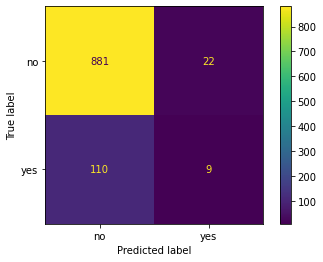

In [110]:
cm_hyp2 = confusion_matrix(y_test_hyp_gluc_array2[:,0], y_hat_test_hyp_gluc2[:,0], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
disp.plot()

In [111]:
report_hyp2 = classification_report(y_test_hyp_gluc_array[:,0], y_hat_test_hyp_gluc[:,0], target_names=["no", "yes"])
print(report_hyp2)

              precision    recall  f1-score   support

          no       0.89      0.98      0.93       903
         yes       0.29      0.08      0.12       119

    accuracy                           0.87      1022
   macro avg       0.59      0.53      0.53      1022
weighted avg       0.82      0.87      0.84      1022



* For the average glucose level predictions:

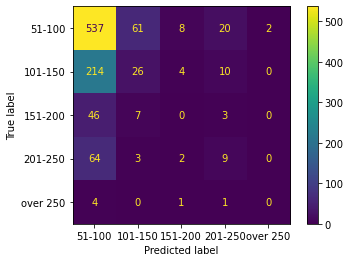

In [113]:
cm_gluc2 = confusion_matrix(y_test_hyp_gluc_array[:,1], y_hat_test_hyp_gluc[:,1], labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gluc2, display_labels=labels_gluc)
disp.plot()

In [114]:
report_gluc2 = classification_report(y_test_hyp_gluc_array[:,1], y_hat_test_hyp_gluc[:,1], target_names=labels_gluc)
print(report_gluc2)

              precision    recall  f1-score   support

      51-100       0.62      0.86      0.72       628
     101-150       0.27      0.10      0.15       254
     151-200       0.00      0.00      0.00        56
     201-250       0.21      0.12      0.15        78
    over 250       0.00      0.00      0.00         6

    accuracy                           0.56      1022
   macro avg       0.22      0.21      0.20      1022
weighted avg       0.46      0.56      0.49      1022



With default parameter XGB did better.

In [218]:
filename = "hypertension_glucose_predictor.sav"
dump(pipe_hyp_gluc_xgb, filename)

['hypertension_glucose_predictor.sav']

# 7. Hypertension and BMI predictions

In [219]:
hypert_bmi = bmi_df.copy()
hypert_bmi["hypertension"] = hypert_bmi["hypertension"].replace({"yes": 1, "no": 0})
hypert_bmi["bmi_bins"] = hypert_bmi["bmi_bins"].replace(
    {"<=17": 0, "18-24": 1, "25-30": 2, "31-35": 3, "35-40": 4, "41<=": 5}
)

In [220]:
X_hyp_bmi= hypert_bmi.drop(columns=["hypertension", "stroke", "bmi", "heart_hypertenz", "log_of_age", "age_bins", "log_of_avg_glucose_level", "glucose_bins", "bmi_bins"],axis=1)
y_hyp_bmi = hypert_bmi[["hypertension", "bmi_bins"]]

In [221]:
X_train_hyp_bmi, X_test_hyp_bmi, y_train_hyp_bmi, y_test_hyp_bmi = train_test_split(X_hyp_bmi, y_hyp_bmi, test_size=0.2, random_state=123)

In [222]:
numerical_hyp_bmi= ["age", "avg_glucose_level"]

one_hot_hyp_bmi = ["work_type", "smoking_status"]

binary_hyp_bmi = ["gender", "heart_disease", "ever_married", "residence_type"]

binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

one_hot_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_hyp_bmi = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_hyp_bmi),
        ("one_hot", one_hot_transformer, one_hot_hyp_bmi),
        ("binary", binary_transformer, binary_hyp_bmi),
    ]
)

In [223]:
pipe_hyp_bmi_forest = Pipeline(
    steps=[
        ("preprocessor", preprocessor_hyp_bmi),
        ("classifier", MultiOutputClassifier(RandomForestClassifier())),
    ]
)

In [224]:
pipe_hyp_bmi_forest.fit(X_train_hyp_bmi, y_train_hyp_bmi)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'ever_married',
                                                   'residence_type'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

Let's check the accuracy score.

In [225]:
print(pipe_hyp_bmi_forest.score(X_train_hyp_bmi, y_train_hyp_bmi))

1.0


In [226]:
y_hat_train_hyp_bmi = pipe_hyp_bmi_forest.predict(X_train_hyp_bmi)
y_hat_test_hyp_bmi = pipe_hyp_bmi_forest.predict(X_test_hyp_bmi)

In [227]:
y_train_hyp_bmi_array = y_train_hyp_bmi.values
y_test_hyp_bmi_array = y_test_hyp_bmi.values

* For the hypertension prediction.

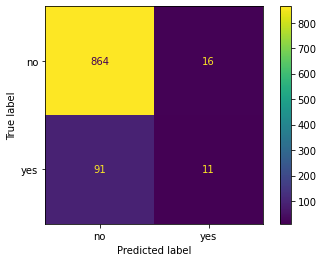

In [228]:
cm_hyp_bmi = confusion_matrix(y_test_hyp_bmi_array[:,0], y_hat_test_hyp_bmi[:,0], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_bmi, display_labels=["no", "yes"])
disp.plot()

In [229]:
# Shows only the hypertension predition.
report_hyp_bmi = classification_report(y_test_hyp_bmi_array[:,0], y_hat_test_hyp_bmi[:,0], target_names=["no", "yes"])
print(report_hyp_bmi)

              precision    recall  f1-score   support

          no       0.90      0.98      0.94       880
         yes       0.41      0.11      0.17       102

    accuracy                           0.89       982
   macro avg       0.66      0.54      0.56       982
weighted avg       0.85      0.89      0.86       982



The recall of hypertension "yes" predictions is very low - 0.10, only 10 times model correctly guesses "yes" from 102 times, model guesses mostly the larger class - hypertension "no". Need's hyperparameter tuning.

* For the bmi part predictions:

In [230]:
labels_bmi= ["<=17", "18-24", "25-30", "31-35", "35-40", "41<="]

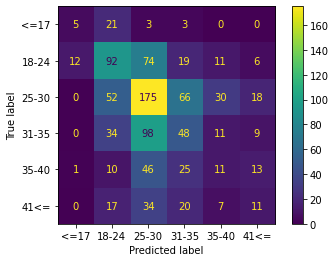

In [231]:
cm_hyp_bmi_bmi = confusion_matrix(y_test_hyp_bmi_array[:,1], y_hat_test_hyp_bmi[:,1], labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_bmi_bmi, display_labels=labels_bmi)
disp.plot()

In [232]:
report = classification_report(y_test_hyp_bmi_array[:,1], y_hat_test_hyp_bmi[:,1], target_names=labels_bmi)
print(report)

              precision    recall  f1-score   support

        <=17       0.28      0.16      0.20        32
       18-24       0.41      0.43      0.42       214
       25-30       0.41      0.51      0.45       341
       31-35       0.27      0.24      0.25       200
       35-40       0.16      0.10      0.13       106
        41<=       0.19      0.12      0.15        89

    accuracy                           0.35       982
   macro avg       0.28      0.26      0.27       982
weighted avg       0.33      0.35      0.33       982



Overall each class of the bmi is predicted differently. Classes, that had more observations in the training set, are predicted a little bit better. 

* Hyperparameter tuning.

In [ ]:
h.forest_randomized_search_multioutput(X_hyp_bmi, y_hyp_bmi, pipe_hyp_bmi_forest)

In [233]:
pipe_hyp_bmi_forest2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_hyp_bmi),
        ("classifier", MultiOutputClassifier(RandomForestClassifier(max_depth=2,
                                                        max_features=9,
                                                        min_samples_leaf=8,
                                                        n_estimators=1200))),
    ]
)

In [234]:
pipe_hyp_bmi_forest2.fit(X_train_hyp_bmi, y_train_hyp_bmi)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'ever_married',
                                                   'residence_type'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=2,
                                                                        max_features=9,
                                                                        min_samples_leaf=8,
                                                                        n_estimators=1200)))])

Let's check the accuracy score.

In [235]:
print(pipe_hyp_bmi_forest2.score(X_train_hyp_bmi, y_train_hyp_bmi))

0.3893985728848114


In [236]:
y_hat_train_hyp_bmi2 = pipe_hyp_bmi_forest2.predict(X_train_hyp_bmi)
y_hat_test_hyp_bmi2 = pipe_hyp_bmi_forest2.predict(X_test_hyp_bmi)

* Hypertension predictions:

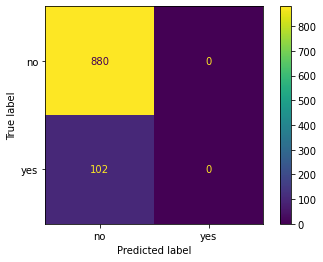

In [237]:
cm_hyp_bmi2 = confusion_matrix(y_test_hyp_bmi_array[:,0], y_hat_test_hyp_bmi2[:,0], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_bmi2, display_labels=["no", "yes"])
disp.plot()

In [238]:
report = classification_report(y_test_hyp_bmi_array[:,0], y_hat_test_hyp_bmi2[:,0], target_names=["no", "yes"])
print(report)

              precision    recall  f1-score   support

          no       0.90      1.00      0.95       880
         yes       0.00      0.00      0.00       102

    accuracy                           0.90       982
   macro avg       0.45      0.50      0.47       982
weighted avg       0.80      0.90      0.85       982



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


* For the bmi part predictions:

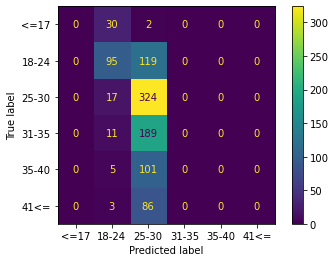

In [239]:
cm_hyp_bmi_bmi2= confusion_matrix(y_test_hyp_bmi_array[:,1], y_hat_test_hyp_bmi2[:,1], labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_bmi_bmi2, display_labels=labels_bmi)
disp.plot()

In [240]:
report = classification_report(y_test_hyp_bmi_array[:,1], y_hat_test_hyp_bmi2[:,1], target_names=labels_bmi)
print(report)

              precision    recall  f1-score   support

        <=17       0.00      0.00      0.00        32
       18-24       0.59      0.44      0.51       214
       25-30       0.39      0.95      0.56       341
       31-35       0.00      0.00      0.00       200
       35-40       0.00      0.00      0.00       106
        41<=       0.00      0.00      0.00        89

    accuracy                           0.43       982
   macro avg       0.16      0.23      0.18       982
weighted avg       0.27      0.43      0.30       982



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Tuned and with default hyperparameters Random Forest Classifier guesses in a quite similar way. I would try to select the most important features for this model and raise the recall of last two bmi classes (big overweight) predictions. Maybe use other up sampler.

In [241]:
filename = "hypertension_bmi_predictor.sav"
dump(pipe_hyp_bmi_forest, filename)

['hypertension_bmi_predictor.sav']

# 8. Average glucose level and BMI prediction

In [242]:
gluc_bmi = bmi_df.copy()
gluc_bmi["glucose_bins"] = gluc_bmi["glucose_bins"].replace(
    {
        "51-100 mg/dl": 0,
        "101-150 mg/dl": 1,
        "201-250 mg/dl": 3,
        "151-200 mg/dl": 2,
        "over 250 mg/dl": 4,
    }
)
gluc_bmi["bmi_bins"] = gluc_bmi["bmi_bins"].replace(
    {"<=17": 0, "18-24": 1, "25-30": 2, "31-35": 3, "35-40": 4, "41<=": 5}
)

In [243]:
X_gluc_bmi = gluc_bmi.drop(
    columns=[
        "stroke",
        "bmi",
        "avg_glucose_level",
        "log_of_age",
        "age_bins",
        "log_of_avg_glucose_level",
        "glucose_bins",
        "bmi_bins",
    ],
    axis=1,
)
y_gluc_bmi = gluc_bmi[["glucose_bins", "bmi_bins"]]

In [244]:
X_train_gluc_bmi, X_test_gluc_bmi, y_train_gluc_bmi, y_test_gluc_bmi = train_test_split(X_gluc_bmi, y_gluc_bmi, test_size=0.2, random_state=123)

In [245]:
numerical_gluc_bmi = ["age"]

one_hot_gluc_bmi = ["work_type", "smoking_status"]

binary_gluc_bmi = [
    "gender",
    "heart_disease",
    "hypertension",
    "heart_hypertenz",
    "ever_married",
    "residence_type",
]

binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

one_hot_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_gluc_bmi = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_gluc_bmi),
        ("one_hot", one_hot_transformer, one_hot_gluc_bmi),
        ("binary", binary_transformer, binary_gluc_bmi),
    ]
)

In [246]:
pipe_gluc_bmi_xgb= Pipeline(
    steps=[
        ("preprocessor", preprocessor_gluc_bmi),
        ("classifier", MultiOutputClassifier(XGBClassifier())),
    ]
)

In [247]:
pipe_gluc_bmi_xgb.fit(X_train_gluc_bmi, y_train_gluc_bmi)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:13:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'hypertension',
                                                   'heart_hyp...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method=None,
                                                               validate_parameters=None,
                                                               verbosity=None)))])

In [248]:
print(pipe_gluc_bmi_xgb.score(X_train_gluc_bmi, y_train_gluc_bmi))

0.4454638124362895


In [249]:
y_hat_train_gluc_bmi = pipe_gluc_bmi_xgb.predict(X_train_gluc_bmi)
y_hat_test_gluc_bmi = pipe_gluc_bmi_xgb.predict(X_test_gluc_bmi)

In [250]:
y_train_gluc_bmi_array = y_train_gluc_bmi.values
y_test_gluc_bmi_array = y_test_gluc_bmi.values

* For the average glucose level bins predictions.

In [251]:
labels_gluc

['51-100', '101-150', '151-200', '201-250', 'over 250']

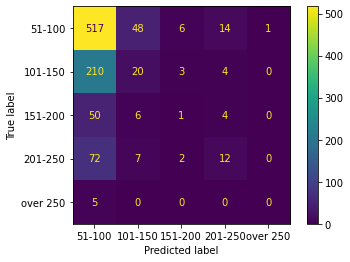

In [252]:
cm_gluc_bmi = confusion_matrix(y_test_gluc_bmi_array[:,0], y_hat_test_gluc_bmi[:,0], labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gluc_bmi, display_labels=labels_gluc)
disp.plot()

In [253]:
report = classification_report(y_test_gluc_bmi_array[:,0], y_hat_test_gluc_bmi[:,0], target_names=labels_gluc)
print(report)

              precision    recall  f1-score   support

      51-100       0.61      0.88      0.72       586
     101-150       0.25      0.08      0.13       237
     151-200       0.08      0.02      0.03        61
     201-250       0.35      0.13      0.19        93
    over 250       0.00      0.00      0.00         5

    accuracy                           0.56       982
   macro avg       0.26      0.22      0.21       982
weighted avg       0.46      0.56      0.48       982



* For the bmi.

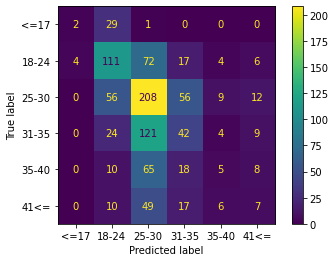

In [254]:
cm_gluc_bmi2 = confusion_matrix(y_test_gluc_bmi_array[:,1], y_hat_test_gluc_bmi[:,1], labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gluc_bmi2, display_labels=labels_bmi)
disp.plot()

In [255]:
report = classification_report(y_test_gluc_bmi_array[:,1], y_hat_test_gluc_bmi[:,1], target_names=labels_bmi)
print(report)

              precision    recall  f1-score   support

        <=17       0.33      0.06      0.11        32
       18-24       0.46      0.52      0.49       214
       25-30       0.40      0.61      0.49       341
       31-35       0.28      0.21      0.24       200
       35-40       0.18      0.05      0.07       106
        41<=       0.17      0.08      0.11        89

    accuracy                           0.38       982
   macro avg       0.30      0.25      0.25       982
weighted avg       0.34      0.38      0.35       982



* Let's tune the hyperparameters.

In [ ]:
xgb_multi_gluc_bmi_params = h.xgb_multioutput_randomized_search(pipe_gluc_bmi_xgb, X_train_gluc_bmi, y_train_gluc_bmi)

In [159]:
xgb_multi_gluc_bmi_params

{'classifier__estimator__colsample_bytree': 0.4,
 'classifier__estimator__gamma': 0.1,
 'classifier__estimator__learning_rate': 0.1,
 'classifier__estimator__max_depth': 3,
 'classifier__estimator__min_child_weight': 1,
 'classifier__estimator__n_estimators': 190,
 'classifier__estimator__num_leaves': 560,
 'classifier__estimator__reg_alpha': 34.94503755711602,
 'classifier__estimator__reg_lambda': 0.04051048683472317,
 'classifier__estimator__scale_pos_weight': 17}

In [256]:
pipe_gluc_bmi_xgb2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_gluc_bmi),
        (
            "classifier",
            MultiOutputClassifier(
                XGBClassifier(
                    colsample_bytree=0.4,
                    gamma=0.1,
                    learning_rate=0.1,
                    max_depth=3,
                    min_child_weight=1,
                    n_estimators=190,
                    num_leaves=560,
                    reg_alpha=34.94503755711602,
                    reg_lambda=0.04051048683472317,
                    scale_pos_weight=17,
                )
            ),
        ),
    ]
)

In [257]:
pipe_gluc_bmi_xgb2.fit(X_train_gluc_bmi, y_train_gluc_bmi)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:14:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_leaves", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:14:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_leaves", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'hypertension',
                                                   'heart_hyp...
                                                               learning_rate=0.1,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=190,
                                                               n_jobs=None,
                                                               num_leaves=560,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=34.94503755711602,
                                                               reg_lambda=0.04051048683472317,
                                                               scale_pos_weight=17,
                                                               subsample=None,
                                                               tree_method=None,
                                                               validate_parameters=None,
                                                               verbosity=None)))])

Let's check the accuracy score.

In [258]:
print(pipe_gluc_bmi_xgb2.score(X_train_gluc_bmi, y_train_gluc_bmi))

0.2686034658511723


In [259]:
y_hat_train_gluc_bmi2 = pipe_gluc_bmi_xgb2.predict(X_train_gluc_bmi)
y_hat_test_gluc_bmi2 = pipe_gluc_bmi_xgb2.predict(X_test_gluc_bmi)

In [260]:
y_train_gluc_bmi_array2 = y_train_gluc_bmi.values
y_test_gluc_bmi_array2 = y_test_gluc_bmi.values

* For the average glucose level bins.

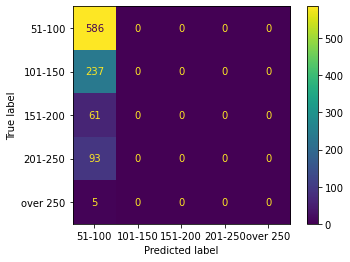

In [261]:
cm_gluc_bmi3 = confusion_matrix(y_test_gluc_bmi_array2[:,0], y_hat_test_gluc_bmi2[:,0], labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gluc_bmi3, display_labels=labels_gluc)
disp.plot()

In [262]:
report = classification_report(y_test_gluc_bmi_array2[:,0], y_hat_test_gluc_bmi2[:,0], target_names=labels_gluc)
print(report)

              precision    recall  f1-score   support

      51-100       0.60      1.00      0.75       586
     101-150       0.00      0.00      0.00       237
     151-200       0.00      0.00      0.00        61
     201-250       0.00      0.00      0.00        93
    over 250       0.00      0.00      0.00         5

    accuracy                           0.60       982
   macro avg       0.12      0.20      0.15       982
weighted avg       0.36      0.60      0.45       982



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


* For the bmi bins.

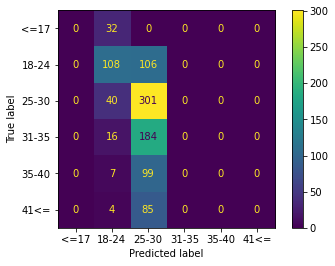

In [263]:
cm2 = confusion_matrix(y_test_gluc_bmi_array2[:,1], y_hat_test_gluc_bmi2[:,1], labels=[0,1,2,3,4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_bmi)
disp.plot()

In [264]:
report = classification_report(y_test_gluc_bmi_array2[:,1], y_hat_test_gluc_bmi2[:,1], target_names=labels_bmi)
print(report)

              precision    recall  f1-score   support

        <=17       0.00      0.00      0.00        32
       18-24       0.52      0.50      0.51       214
       25-30       0.39      0.88      0.54       341
       31-35       0.00      0.00      0.00       200
       35-40       0.00      0.00      0.00       106
        41<=       0.00      0.00      0.00        89

    accuracy                           0.42       982
   macro avg       0.15      0.23      0.18       982
weighted avg       0.25      0.42      0.30       982



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Again, model with default hyperparameters did better.

In [265]:
filename = "glucose_bmi_predictor.sav"
dump(pipe_gluc_bmi_xgb, filename)

['glucose_bmi_predictor.sav']

# 9. Hypertension, average glucose level and body mass index bins predictions

In [266]:
hypert_gluc_bmi = bmi_df.copy()
hypert_gluc_bmi["hypertension"] = hypert_gluc_bmi["hypertension"].replace(
    {"yes": 1, "no": 0}
)
hypert_gluc_bmi["glucose_bins"] = hypert_gluc_bmi["glucose_bins"].replace(
    {
        "51-100 mg/dl": 0,
        "101-150 mg/dl": 1,
        "201-250 mg/dl": 3,
        "151-200 mg/dl": 2,
        "over 250 mg/dl": 4,
    }
)
hypert_gluc_bmi["bmi_bins"] = hypert_gluc_bmi["bmi_bins"].replace(
    {"<=17": 0, "18-24": 1, "25-30": 2, "31-35": 3, "35-40": 4, "41<=": 5}
)

In [267]:
X_hyp_gluc_bmi= hypert_gluc_bmi.drop(columns=["hypertension", "avg_glucose_level", "bmi", "heart_hypertenz", "log_of_age", "age_bins", "log_of_avg_glucose_level", "glucose_bins", "bmi_bins"],axis=1)
y_hyp_gluc_bmi = hypert_gluc_bmi[["hypertension", "glucose_bins", "bmi_bins"]]

In [268]:
X_train_hyp_gluc_bmi, X_test_hyp_gluc_bmi, y_train_hyp_gluc_bmi, y_test_hyp_gluc_bmi = train_test_split(X_hyp_gluc_bmi, y_hyp_gluc_bmi, test_size=0.2, random_state=123)

In [269]:
numerical_hyp_gluc_bmi= ["age"]

one_hot_hyp_gluc_bmi = ["work_type", "smoking_status"]

binary_hyp_gluc_bmi = ["gender", "heart_disease", "ever_married", "residence_type", "stroke"]

binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

one_hot_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_hyp_gluc_bmi = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_hyp_gluc_bmi),
        ("one_hot", one_hot_transformer, one_hot_hyp_gluc_bmi),
        ("binary", binary_transformer, binary_hyp_gluc_bmi),
    ]
)

In [270]:
pipe_hyp_gluc_bmi_forest = Pipeline(
    steps=[
        ("preprocessor", preprocessor_hyp_gluc_bmi),
        ("classifier", MultiOutputClassifier(RandomForestClassifier())),
    ]
)

In [271]:
pipe_hyp_gluc_bmi_forest.fit(X_train_hyp_gluc_bmi, y_train_hyp_gluc_bmi)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'ever_married',
                                                   'residence_type',
                                                   'stroke'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

Let's check the accuracy score.

In [272]:
print(pipe_hyp_gluc_bmi_forest.score(X_train_hyp_gluc_bmi, y_train_hyp_gluc_bmi))

0.5863914373088684


In [273]:
y_hat_train_hyp_gluc_bmi = pipe_hyp_gluc_bmi_forest.predict(X_train_hyp_gluc_bmi)
y_hat_test_hyp_gluc_bmi = pipe_hyp_gluc_bmi_forest.predict(X_test_hyp_gluc_bmi)

In [274]:
y_train_hyp_gluc_bmi_array = y_train_hyp_gluc_bmi.values
y_test_hyp_gluc_bmi_array = y_test_hyp_gluc_bmi.values

* For the hypertension predictions.

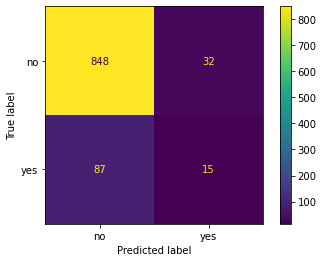

In [275]:
cm_hyp_gluc_bmi = confusion_matrix(y_test_hyp_gluc_bmi_array[:,0], y_hat_test_hyp_gluc_bmi[:,0], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_gluc_bmi, display_labels=["no", "yes"])
disp.plot()

In [276]:
report = classification_report(y_test_hyp_gluc_bmi_array[:,0], y_hat_test_hyp_gluc_bmi[:,0], target_names=["no", "yes"])
print(report)

              precision    recall  f1-score   support

          no       0.91      0.96      0.93       880
         yes       0.32      0.15      0.20       102

    accuracy                           0.88       982
   macro avg       0.61      0.56      0.57       982
weighted avg       0.85      0.88      0.86       982



* For the average glucose level predictions:

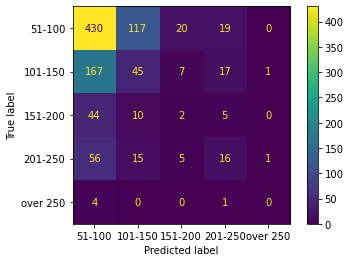

In [277]:
cm_hyp_gluc_bmi2 = confusion_matrix(y_test_hyp_gluc_bmi_array[:,1], y_hat_test_hyp_gluc_bmi[:,1], labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_gluc_bmi2, display_labels=labels_gluc)
disp.plot()

In [278]:
report = classification_report(y_test_hyp_gluc_bmi_array[:,1], y_hat_test_hyp_gluc_bmi[:,1], target_names=labels_gluc)
print(report)

              precision    recall  f1-score   support

      51-100       0.61      0.73      0.67       586
     101-150       0.24      0.19      0.21       237
     151-200       0.06      0.03      0.04        61
     201-250       0.28      0.17      0.21        93
    over 250       0.00      0.00      0.00         5

    accuracy                           0.50       982
   macro avg       0.24      0.23      0.23       982
weighted avg       0.45      0.50      0.47       982



* For the bmi predictions:

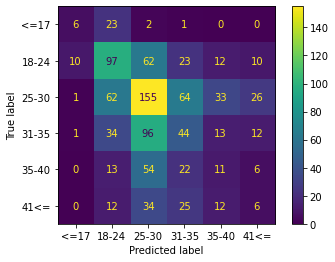

In [279]:
cm_hyp_gluc_bmi3 = confusion_matrix(y_test_hyp_gluc_bmi_array[:,2], y_hat_test_hyp_gluc_bmi[:,2], labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_gluc_bmi3, display_labels=labels_bmi)
disp.plot()

In [280]:
report = classification_report(y_test_hyp_gluc_bmi_array[:,2], y_hat_test_hyp_gluc_bmi[:,2], target_names=labels_bmi)
print(report)

              precision    recall  f1-score   support

        <=17       0.33      0.19      0.24        32
       18-24       0.40      0.45      0.43       214
       25-30       0.38      0.45      0.42       341
       31-35       0.25      0.22      0.23       200
       35-40       0.14      0.10      0.12       106
        41<=       0.10      0.07      0.08        89

    accuracy                           0.32       982
   macro avg       0.27      0.25      0.25       982
weighted avg       0.31      0.32      0.31       982



* Hyperparameter tuning.

In [ ]:
h.forest_randomized_search_multioutput(X_hyp_gluc_bmi, y_hyp_gluc_bmi, pipe_hyp_gluc_bmi_forest)

In [282]:
pipe_hyp_gluc_bmi_forest2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_hyp_gluc_bmi),
        ("classifier", MultiOutputClassifier(RandomForestClassifier(class_weight='balanced',
                                                        max_depth=2,
                                                        max_features=9,
                                                        min_samples_leaf=6,
                                                        n_estimators=1600))),
    ]
)

In [283]:
pipe_hyp_gluc_bmi_forest2.fit(X_train_hyp_gluc_bmi, y_train_hyp_gluc_bmi)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'heart_disease',
                                                   'ever_married',
                                                   'residence_type',
                                                   'stroke'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=2,
                                                                        max_features=9,
                                                                        min_samples_leaf=6,
                                                                        n_estimators=1600)))])

It's terrible.
* Hypertension predictions.

In [285]:
y_hat_train_hyp_gluc_bmi3 = pipe_hyp_gluc_bmi_forest2.predict(X_train_hyp_gluc_bmi)
y_hat_test_hyp_gluc_bmi3 = pipe_hyp_gluc_bmi_forest2.predict(X_test_hyp_gluc_bmi)

* For the hypertension predictions.

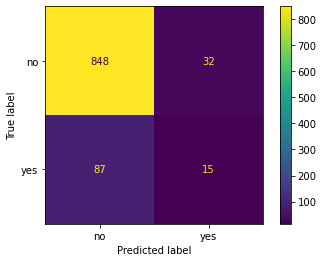

In [286]:
cm_hyp_gluc_bmi = confusion_matrix(y_test_hyp_gluc_bmi_array[:,0], y_hat_test_hyp_gluc_bmi3[:,0], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_gluc_bmi, display_labels=["no", "yes"])
disp.plot()

In [287]:
report = classification_report(y_test_hyp_gluc_bmi_array[:,0], y_hat_test_hyp_gluc_bmi3[:,0], target_names=["no", "yes"])
print(report)

              precision    recall  f1-score   support

          no       0.91      0.96      0.93       880
         yes       0.32      0.15      0.20       102

    accuracy                           0.88       982
   macro avg       0.61      0.56      0.57       982
weighted avg       0.85      0.88      0.86       982



* For the average glucose level predictions:

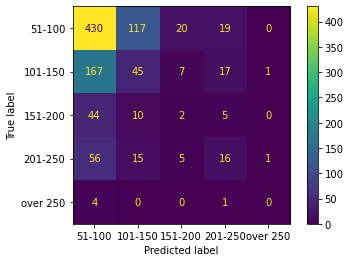

In [288]:
cm_hyp_gluc_bmi2 = confusion_matrix(y_test_hyp_gluc_bmi_array[:,1], y_hat_test_hyp_gluc_bmi3[:,1], labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_gluc_bmi2, display_labels=labels_gluc)
disp.plot()

In [289]:
report = classification_report(y_test_hyp_gluc_bmi_array[:,1], y_hat_test_hyp_gluc_bmi3[:,1], target_names=labels_gluc)
print(report)

              precision    recall  f1-score   support

      51-100       0.61      0.73      0.67       586
     101-150       0.24      0.19      0.21       237
     151-200       0.06      0.03      0.04        61
     201-250       0.28      0.17      0.21        93
    over 250       0.00      0.00      0.00         5

    accuracy                           0.50       982
   macro avg       0.24      0.23      0.23       982
weighted avg       0.45      0.50      0.47       982



* For the bmi predictions:

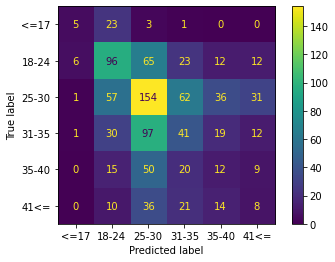

In [458]:
cm_hyp_gluc_bmi3 = confusion_matrix(y_test_hyp_gluc_bmi_array[:,2], y_hat_test_hyp_gluc_bmi3[:,2], labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hyp_gluc_bmi3, display_labels=labels_bmi)
disp.plot()

In [459]:
report = classification_report(y_test_hyp_gluc_bmi_array[:,2], y_hat_test_hyp_gluc_bmi3[:,2], target_names=labels_bmi)
print(report)

              precision    recall  f1-score   support

        <=17       0.38      0.16      0.22        32
       18-24       0.42      0.45      0.43       214
       25-30       0.38      0.45      0.41       341
       31-35       0.24      0.20      0.22       200
       35-40       0.13      0.11      0.12       106
        41<=       0.11      0.09      0.10        89

    accuracy                           0.32       982
   macro avg       0.28      0.24      0.25       982
weighted avg       0.31      0.32      0.31       982



In [307]:
filename = "hypertension_glucose_bmi_predictor.sav"
dump(pipe_hyp_gluc_bmi_forest, filename)

['hypertension_glucose_bmi_predictor.sav']

# Conclusion

* The initial purpose was to investigate, do engineered features (like bins of age, logged values) could improve the models performance, that was tested through the base line models. But mainly the main features of the dataset showed a little better performance.
* Data set is strongly imbalanced, it was tried to solve with different types of SMOTE. 
* Trying different models and different ways to see the feature importance, mostly "age", "avg_glucose_level", "bmi" were those, which gave more chances to predict stroke.
* Mostly all models were evaluated through the recall of predictions of the lower in observations class. For example: stroke -> "yes", hypertension -> "yes", glucose level -> bins with the highest values, bmi_bins -> highest overweight. 
* MultiOutputClassifier (wrapper) is not an option for guessing two and more target variables. I think for further improvement I would build separate models, as then you can tune hyper parameters of each separately, use different classifier (estimators) for each and different features (combinations of them). For example RandomForestClassifier() was quite normal (according to accuracy score) in predicting hypertension (binary output), but went very bad in predicting multi labels of average glucose bins and bmi bins.
* All in all, it's a trade off: if hospital can allow more False positive stroke cases, then the focus must be on getting better recall of "yes" ("1"), if it cannot allow so many "False patients" to occur, the the balance between False positives and False negatives must be reached.
* It's quite impossible from this dataset of 5000 observations, to predict everything about humans body and health: stroke, bmi, glucose level, hypertension. Mostly we have a set of features, life stile, eating and physical activity habits, physical parameters, that can indicate some kind of condition. In this data set these features were not enough.
